## Objective
Run algorithm on spikeinterface recording

si_rec9.ipynb -> si_rec10.ipynb: Returning to full RT-Sort after testing kilosort as RT-Sort sequences

si_rec10_copy.ipynb is used for sanity check on patch clamp recording (sequences used to not detect spikes in patch clamp recordings)

## Globals setup

In [3]:
%load_ext autoreload

In [4]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

# Only for testing
from diptest import diptest
from sklearn.mixture import GaussianMixture

%autoreload 2
from src import utils, recording
from src.run_alg import si_rec10_copy as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)
from src.sorters.base import Unit

In [5]:
# SI recording
# TRAINING_MS = (0, 5*60*1000)  # 0 min to 5 min in recording 
# TESTING_MS = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording

# First patch clamp
TRAINING_MS = (0, 5*60*1000)  # First 5min # (0, 18019800/20) # Full 15min
TESTING_MS = (18019800/20, 29231400/20)

In [6]:
# SI recording
# RECORDING = utils.rec_si()
# CHANS_RMS = utils.chans_rms_si()

# First patch clamp recording
RECORDING = recording.Recording("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cat.si")
CHANS_RMS = np.full((RECORDING.get_num_channels(),), 1)  # Need to calculate these values

SAMP_FREQ = RECORDING.get_sampling_frequency()
NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = RECORDING.get_channel_locations()

In [7]:
ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   

In [8]:
# SI recording
# ALL_CROSSINGS = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings.npy", allow_pickle=True)
# ELEC_CROSSINGS_IND = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/elec_crossings_ind.npy", allow_pickle=True)
# ALL_CROSSINGS = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/all_crossings_10%.npy", allow_pickle=True)
# ELEC_CROSSINGS_IND = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/elec_crossings_ind_10%.npy", allow_pickle=True)

# First patch clamp recordings
ALL_CROSSINGS = np.load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/all_crossings.npy", allow_pickle=True)
ELEC_CROSSINGS_IND = np.load('/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/elec_crossings_ind.npy', allow_pickle=True)

## Reformat for faster retrieval
ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]
ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]

In [9]:
# SI recording
# TRACES_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/traces.npy"  # NOTE: 12/10/23 For neuropixels, these are AFTER multiplying by gain_to_uv
# TRACES_FILT_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/traces_filt.npy"
# MODEL_OUTPUTS_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/outputs.npy"

# First patch clamp recording
TRACES = np.memmap("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cat.si/traces_cached_seg0.raw", dtype="uint16", mode="r", shape=(29231400, 902)).T
OUTPUTS = np.load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/outputs.npy", mmap_mode="r")

FRONT_BUFFER = 40  # Model's front sample buffer

In [10]:
class TracesFiltWrapper:
    """
    Wrapper for RECORDING so it can be used for TRACES_FILT
    """
    def __init__(self, recording):
        self.recording = recording
        self.chans = range(recording.get_num_channels())
        # self.frames = range(recording.get_total_samples()) 
        self.shape = (recording.get_num_channels(), recording.get_total_samples())
        
    def __getitem__(self, idx):
        chans, frames = idx  # unpacking like this is okay since TRACES_FILT[:] is never called
        chans = self.chans[chans]
        return self.recording.get_traces_filt(frames.start, frames.stop, chans)
TRACES_FILT = TracesFiltWrapper(RECORDING)

In [189]:
# Set global variables in .py
reload(F)

F.RECORDING = RECORDING
F.CHANS_RMS = CHANS_RMS
F.SAMP_FREQ = SAMP_FREQ
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS

F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

F.ALL_CROSSINGS = ALL_CROSSINGS
F.ELEC_CROSSINGS_IND = ELEC_CROSSINGS_IND

# F.TRACES_FILT_PATH = TRACES_FILT_PATH
# F.MODEL_OUTPUTS_PATH = MODEL_OUTPUTS_PATH
F.FRONT_BUFFER = FRONT_BUFFER

# TODO: Make sure traces is in (num_elecs, num_samples) format
F.TRACES = TRACES  # NOTE: 12/10/23 For neuropixels, these are AFTER multiplying by gain_to_uv
F.TRACES_FILT = TRACES_FILT
F.OUTPUTS = OUTPUTS

F.N_BEFORE = F.N_AFTER = round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections

## Form propagations

In [223]:
np.seterr("raise")

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

### Development

In [190]:
# TEST find number of detections on each electrode
# Need to edit form_coc_clusters for this part to return coc_dict
def job(elec):
    return F.form_coc_clusters(elec, TRAINING_MS)

all_coc_dicts = []
with Pool(processes=12) as pool:
    for coc_dict in tqdm(pool.imap_unordered(job, range(NUM_ELECS), chunksize=10), total=NUM_ELECS):
        all_coc_dicts.append(coc_dict)

100%|██████████| 902/902 [11:18<00:00,  1.33it/s] 


  0%|          | 0/902 [00:00<?, ?it/s]

100%|██████████| 902/902 [00:00<00:00, 4396.50it/s]


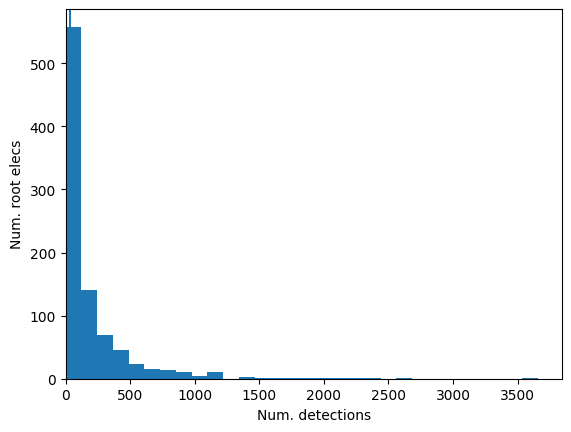

309/902 below 30 cocs


In [196]:
# TEST continued
THRESH = 30

nums_crossings = []
for coc_dict in tqdm(all_coc_dicts):
    num = 0
    for time, cocs in coc_dict.items():
        if len(cocs) >= 2:
            num += 1
    nums_crossings.append(num)
nums_crossings = np.array(nums_crossings)

plt.hist(nums_crossings, bins=30)
plt.axvline(30)
plt.xlim(0)
plt.xlabel("Num. detections")
plt.ylabel("Num. root elecs")
plt.show()

print(f"{np.sum(nums_crossings < THRESH)}/{len(nums_crossings)} below {THRESH} cocs")

In [ ]:
# form_from_root
root_elec=5

time_frame=TRAINING_MS
verbose=True

coc_clusters = F.form_coc_clusters(root_elec, time_frame, 
                                   verbose=verbose)
# F.setup_coc_clusters(coc_clusters, verbose=verbose)

In [106]:
F.form_from_root(67, TRAINING_MS, max_latency_diff=1.67, max_amp_median_diff=0.35, verbose=True)

Starting with elec 67, loc: [3062.5  945. ]

Finding coocurrences


  3%|▎         | 101/3691 [00:00<00:03, 1007.73it/s]

100%|██████████| 3691/3691 [00:08<00:00, 441.18it/s]


206 cocs total

Unimodal amp/median with p-value: 0.912

Comparing to elec 199, loc: [3045.  945.]
Found 1 clusters
194 cocs remaining

Comparing to elec 431, loc: [3062.5  962.5]
Found 1 clusters
170 cocs remaining

Comparing to elec 529, loc: [3080.  945.]
Found 1 clusters
127 cocs remaining

Comparing to elec 183, loc: [3045.   962.5]
Found 1 clusters
94 cocs remaining

Comparing to elec 124, loc: [3062.5  980. ]
Found 1 clusters
67 cocs remaining

Comparing to elec 127, loc: [3027.5  945. ]
Found 1 clusters
33 cocs remaining

Comparing to elec 138, loc: [3045.  910.]
Found 1 clusters
15 cocs remaining

Comparing to elec 205, loc: [3080.  980.]
Found 1 clusters
0 cocs remaining

Ending early because too few cocs remaining

Total: 8 clusters


100%|██████████| 14247222/14247222 [00:16<00:00, 881661.30it/s] 



Merged 0 with 1
Latency diff: 0.32. Amp median diff: 0.23
Amp dist p-value 0.7879
#spikes:
Merge base: 32, Add: 24, Overlaps: 0
After merging: 54

Formed 1 merged clusters:
cluster 0: [0, 1]


In [ ]:
for cluster in coc_clusters:
    F.plot_elec_probs(cluster)
    plt.show()

In [32]:
old_coc_clusters = coc_clusters

In [33]:
coc_clusters = deepcopy(old_coc_clusters)

In [77]:
F.setup_coc_clusters(coc_clusters, verbose=True)

  7%|▋         | 1/14 [00:00<00:02,  4.76it/s]

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


In [ ]:
F.assign_spikes(coc_clusters, time_frame, verbose=verbose)
print(len(coc_clusters))
coc_clusters = [c for c in coc_clusters if len(c._spike_train) >= 3]
print(len(coc_clusters))

In [ ]:
merged_clusters = F.merge_coc_clusters(deepcopy(coc_clusters), verbose=True,
                                       max_amp_median_diff=0.35)

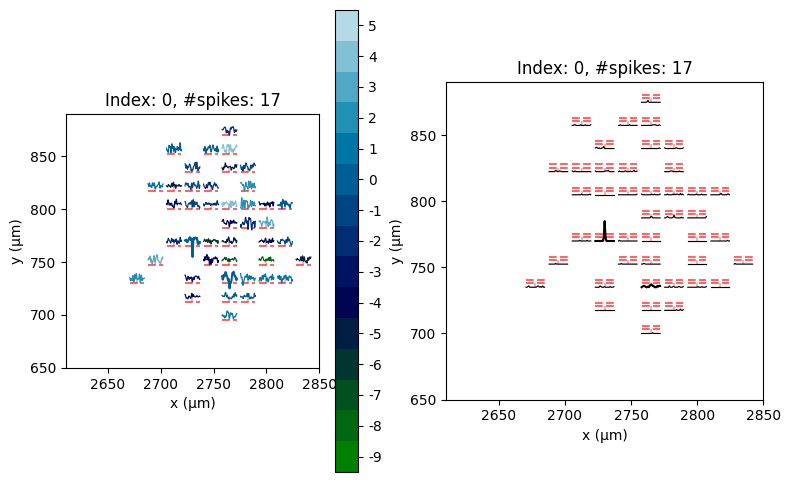

dip p-val: 0.988


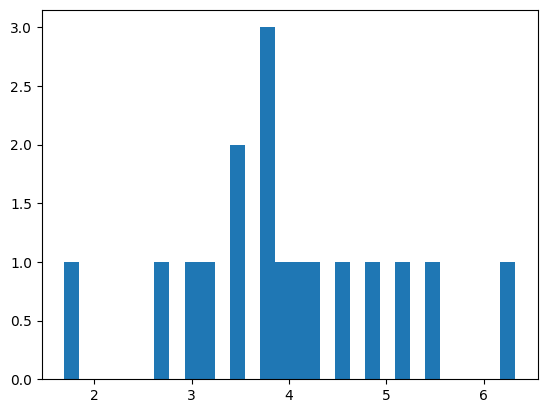

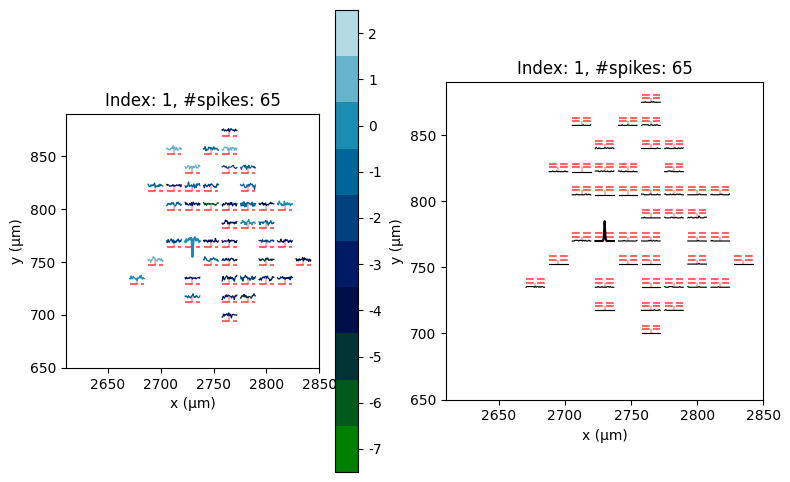

dip p-val: 0.896


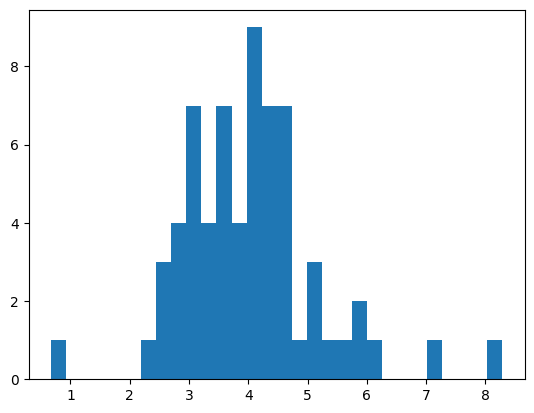

In [39]:
for i, cluster in enumerate(coc_clusters[12:]): 
    # Test formation spikes
    spike_train = cluster.spike_train
    # cluster._spike_train = cluster.formation_spike_train
    
    F.plot_elec_probs(cluster, idx=i)
    plt.show()
    
    amp_medians = F.get_amp_medians(cluster, n_cocs=None).flatten()
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")
    
    plt.hist(amp_medians, bins=30)
    plt.show()
    
    # Test formation spikes
    cluster._spike_train = spike_train


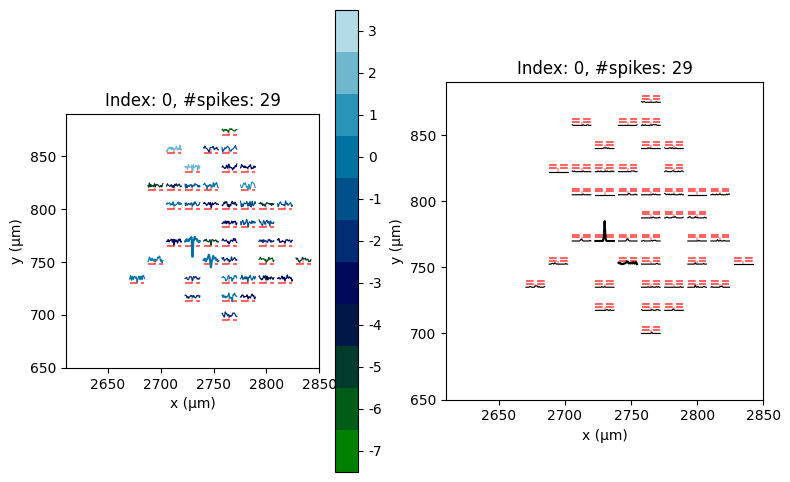

In [15]:
# for cluster in coc_clusters:
#     print()
#     print(cluster.loose_elecs)
#     print(cluster.comp_elecs)
    
cluster = coc_clusters[3]
F.plot_elec_probs(cluster)
plt.show()

2 components, score: 2798.54
3 components, score: 2819.75
4 components, score: 2829.00


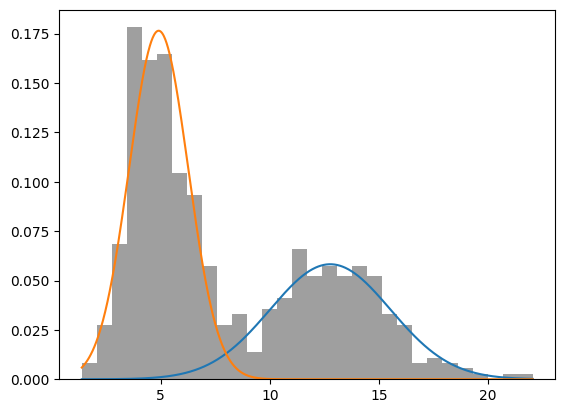

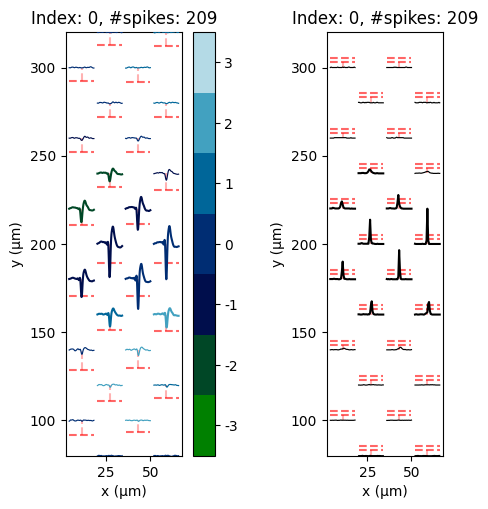

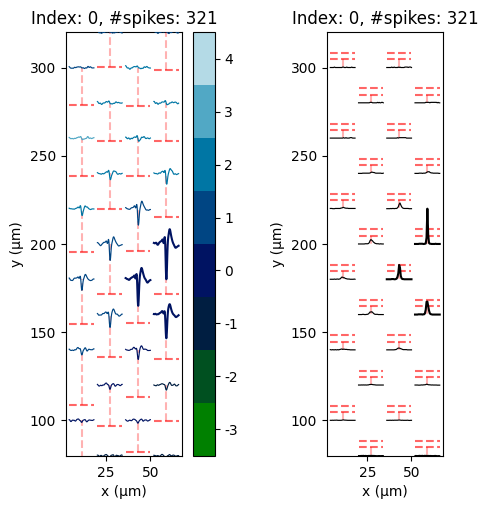

In [76]:
cluster = coc_clusters[-1]
root_amp_medians = F.get_amp_medians(cluster, n_cocs=None, use_formation_spike_train=True)
best_score = np.inf
best_gmm = None
for n_components in range(2, 4+1):
    gmm = GaussianMixture(n_components=n_components, random_state=1150)
    gmm.fit(root_amp_medians)
    score = gmm.bic(root_amp_medians)
    print(f"{n_components} components, score: {score:.2f}")
    if score < best_score:
        best_score = score
        best_gmm = gmm
        
plt.hist(root_amp_medians, bins=30, density=True, alpha=0.5, color='gray')

# Plot the PDFs of individual components
F.plot_gmm(best_gmm, root_amp_medians)
plt.show()

predictions = best_gmm.predict(root_amp_medians)
train1 = cluster.formation_spike_train[predictions==0]
cluster._spike_train = train1
F.plot_elec_probs(cluster)
plt.show()

train2 = cluster.formation_spike_train[predictions==1]
cluster._spike_train = train2
F.plot_elec_probs(cluster)
plt.show()

In [40]:
## Examine merge scores of seq pair

cluster_i = trained_sequences[70]
cluster_j = trained_sequences[71]

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
print(f"Elec overlap: {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:]
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.abs(i_latencies - j_latencies)
latency_diff = np.clip(latency_diff, a_min=None, a_max=F.CLIP_LATENCY_DIFF)
latency_diff = np.sum(latency_diff * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.clip(amp_median_diff, a_min=None, a_max=F.CLIP_AMP_MEDIAN_DIFF)
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    print(f"Elec {root_elec} p-val: {pval:.2f}")

Elec overlap: 1.00
Latency diff: 0.38
Amp diff : 0.21
Elec 32 p-val: 0.45


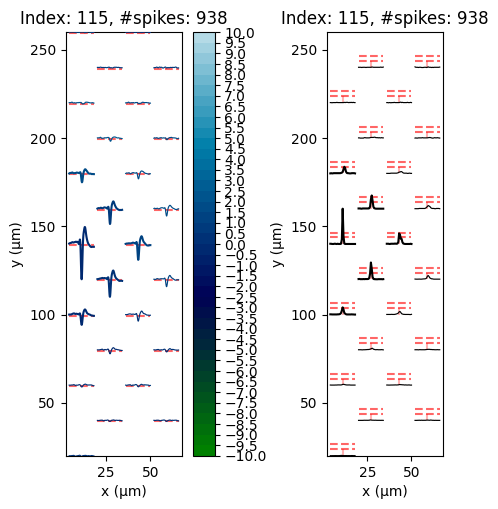

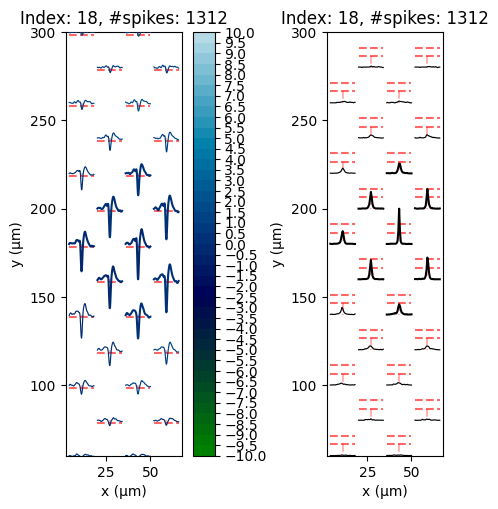

In [37]:
F.plot_elec_probs(cluster_i)
plt.show()
F.plot_elec_probs(cluster_j)
plt.show()

In [285]:
print(cluster_i.loose_elecs)
print(cluster_j.loose_elecs)

[13 15 17 18 19]
[11 13 14 15 17 19]


In [ ]:
F.setup_coc_clusters(merges)
pair = F.Merge(merges[0], merges[1])
pair.summarize()

Latency diff: 1.16. Rel amp diff: 0.33
Amp dist p-value 0.0541


#### Assigning spikes before or after merging?

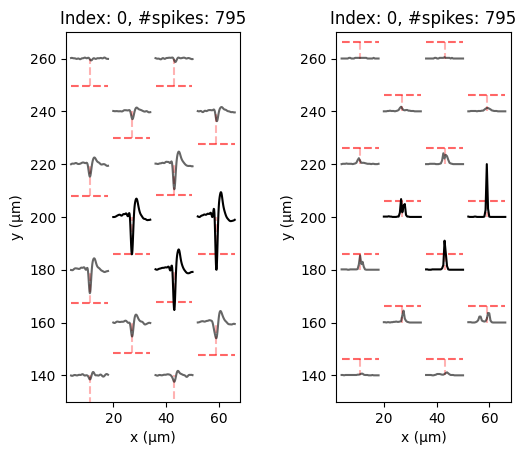

795


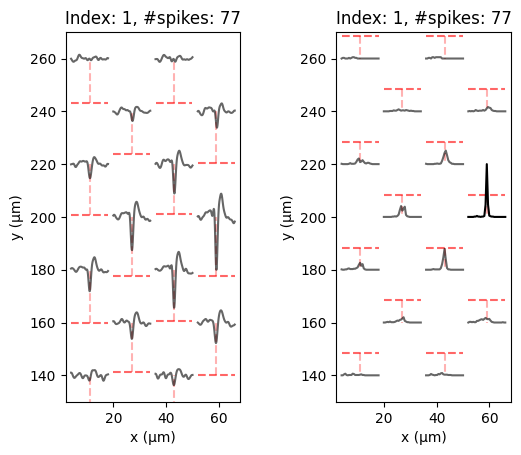

In [ ]:
intra_only = set(intra_merges[0].spike_train).difference(merges[0].spike_train)
unit = Unit(0, list(intra_only), 17, RECORDING)
F.plot_elec_probs(unit)
plt.show()

inter_only = set(merges[0].spike_train).difference(intra_merges[0].spike_train)
unit = Unit(1, list(inter_only), 17, RECORDING)
F.plot_elec_probs(unit)
plt.show()


In [ ]:
intra = deepcopy(merges)
F.assign_spikes(intra, TRAINING_FRAMES, interelec=False, verbose=True)
for m in intra:
    print(len(m.spike_train))

inter = deepcopy(merges)
F.assign_spikes(inter, TRAINING_FRAMES, interelec=True, verbose=True)
for m in inter:
    print(len(m.spike_train))


100%|██████████| 2451452/2451452 [00:10<00:00, 240980.66it/s]


1947
381
2073


100%|██████████| 2451452/2451452 [00:10<00:00, 230100.55it/s]

1942
379
2068


In [ ]:
set(intra[-1].spike_train).difference(inter[-1].spike_train)

{1135.8666666666666,
 1904.5333333333333,
 1943.8666666666666,
 2236.266666666667,
 2668.6,
 3010.4,
 3031.6,
 3077.366666666667,
 5491.333333333333,
 6049.8,
 6129.766666666666,
 6192.133333333333,
 7484.666666666667,
 7523.166666666667,
 7858.466666666666,
 7866.333333333333,
 7967.033333333334,
 8271.166666666666,
 8470.7,
 8863.266666666666,
 8954.1,
 9167.766666666666,
 9235.7,
 9852.9,
 10647.333333333334,
 10683.7,
 10976.633333333333,
 11049.466666666667,
 11649.9,
 11828.433333333332,
 11888.933333333332,
 12603.366666666667,
 13241.966666666667,
 13315.766666666666,
 13464.366666666667,
 13473.666666666666,
 13631.3,
 13837.666666666666,
 14734.833333333334,
 15523.733333333334,
 16609.9,
 16673.566666666666,
 16755.966666666667,
 16763.566666666666,
 16767.9,
 17047.333333333332,
 17194.4,
 18156.833333333332,
 18392.233333333334,
 19806.666666666668,
 19842.133333333335,
 20722.7,
 20727.0,
 20756.966666666667,
 20967.866666666665,
 21761.5,
 23130.433333333334,
 23151.5333

### Full run

In [19]:
# SI rec
# ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/240103/no_max_amp_only")

# First patch clamp 
ROOT_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240109")
ROOT_PATH.mkdir(exist_ok=True)

MAX_LATENCY_DIFF = 1.67 # 2.51
MAX_AMP_MEDIAN_DIFF = 0.35

MIN_SPIKES = 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000

In [101]:
import os
def job(root_elec):
    testing = f"/data/MEAprojects/PropSignal/MAX_DELETE_ME/rt_sort_run_time_data/{root_elec}" 
    with open(testing, "w") as f:
        pass
    
    merges = F.form_from_root(root_elec, TRAINING_MS,
                  max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF)
    
    os.remove(testing)

    return merges
  
np.random.seed(1150)
all_sequences = []
with Pool(processes=15) as pool:
    for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
    # for sequences in tqdm(pool.imap_unordered(job, range(5)), total=NUM_ELECS):
        all_sequences += sequences
for idx, seq in enumerate(all_sequences):
    seq.idx = idx
all_sequences_before_inter = deepcopy(all_sequences)
print(f"{len(all_sequences)} sequences before interelec merging")

  4%|▍         | 39/902 [47:23<17:28:48, 72.92s/it] Process ForkPoolWorker-164:
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_2889757/2681429333.py", line 7, in job
    max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF)
  File "/data/MEAprojects/PropSignal/src/run_alg/si_rec10_copy.py", line 2262, in form_from_root
    coc_clusters = form_coc_clusters(root_elec, time_frame, verbose=verbose)
  File "/data/MEAprojects/PropSignal/src/run_alg/si_rec10_copy.py", line 764, in form_coc_clusters
    pre_means, pre_medians = calc_pre_mean_median(start_frame, max_a

KeyboardInterrupt: 

In [24]:
# No parallel full run
# for root_elec in tqdm(range(NUM_ELECS)):
#     merges = F.form_from_root(root_elec, TRAINING_MS, max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF)
#     utils.pickle_dump(merges, ROOT_PATH / f"merges/merges_{root_elec}.pickle")

all_sequences = []
num_no_seq_elecs = 0
idx = 0
for root_elec in tqdm(range(NUM_ELECS)):
    merges = utils.pickle_load(ROOT_PATH / f"merges/merges_{root_elec}.pickle")
    if len(merges) > 0:
        for merg in merges:
            merg.idx = idx
            idx += 1
            all_sequences.append(merg)
    else:
        num_no_seq_elecs += 1
print(f"{len(all_sequences)} sequences before interelec merging")
print(f"Root elecs with no sequences: {num_no_seq_elecs}/{NUM_ELECS}")

  3%|▎         | 27/902 [00:00<00:03, 262.84it/s]

100%|██████████| 902/902 [00:05<00:00, 163.64it/s]

669 sequences before interelec merging
Root elecs with no sequences: 542


In [ ]:
# # Trying to use joblib to handle GMM 
# from joblib import Parallel, delayed
# from pathlib import Path

# def job(start_root_elec):
#     F.CHANS_RMS = CHANS_RMS
#     F.SAMP_FREQ = SAMP_FREQ
#     F.NUM_ELECS = NUM_ELECS
#     F.ELEC_LOCS = ELEC_LOCS

#     F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

#     F.ALL_CROSSINGS = np.load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/all_crossings.npy", allow_pickle=True)
#     F.ELEC_CROSSINGS_IND = np.load('/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/elec_crossings_ind.npy', allow_pickle=True)

#     F.FRONT_BUFFER = FRONT_BUFFER

#     # TODO: Make sure traces is in (num_elecs, num_samples) format
#     F.TRACES = np.memmap("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cat.si/traces_cached_seg0.raw", dtype="uint16", mode="r", shape=(29231400, 902)).T
#     F.OUTPUTS = np.load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/outputs.npy", mmap_mode="r")

#     F.N_BEFORE = F.N_AFTER = round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections
    
#     # all_merges = []
#     # for root_elec in range(start_root_elec, min(start_root_elec+BATCH_SIZE, NUM_ELECS)):
#     #     merges = F.form_from_root(root_elec, TRAINING_MS,
#     #                 max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF)
#     #     all_merges.extend(merges)
#     # return merges

# from math import ceil
# BATCH_SIZE = ceil(NUM_ELECS / 20)
# tasks = range(0, NUM_ELECS, BATCH_SIZE)
# all_sequences = Parallel(n_jobs=10, verbose=231)(delayed(job)(t) for t in tasks)

: 

: 

: 

In [34]:
utils.pickle_dump(all_sequences, ROOT_PATH / "all_sequences.pickle")

In [ ]:
all_sequences = utils.pickle_load(ROOT_PATH / "all_sequences.pickle")

In [35]:
merged_sequences = all_sequences # utils.pickle_load(ROOT_PATH / "all_sequences.pickle")  # deepcopy(all_sequences)
print("NEED TO CHECK THAT AFTERMERGING AND OVERLAPS, THERE IS NO BUG")
merged_sequences = F.merge_coc_clusters(merged_sequences, max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                                        auto_setup_coc_clusters=False, 
                                        verbose=True)


NEED TO CHECK THAT AFTERMERGING AND OVERLAPS, THERE IS NO BUG

Merged 251 with 526
Latency diff: 0.00. Amp median diff: 0.01
Amp dist p-value 0.6085
#spikes:
Merge base: 1505, Add: 1477, Overlaps: 1409
After merging: 1573

Merged 464 with 591
Latency diff: 0.00. Amp median diff: 0.01
Amp dist p-value 0.6189
#spikes:
Merge base: 2149, Add: 2397, Overlaps: 2112
After merging: 2432

Merged 108 with 539
Latency diff: 0.04. Amp median diff: 0.01
Amp dist p-value 0.7466
#spikes:
Merge base: 1412, Add: 1535, Overlaps: 1367
After merging: 1575

Merged [108, 539] with 454
Latency diff: 0.01. Amp median diff: 0.01
Amp dist p-value 0.7004
#spikes:
Merge base: 1575, Add: 1388, Overlaps: 1370
After merging: 1594

Merged 239 with 283
Latency diff: 0.00. Amp median diff: 0.02
Amp dist p-value 0.3893
#spikes:
Merge base: 190, Add: 171, Overlaps: 164
After merging: 198

Merged 85 with 242
Latency diff: 0.00. Amp median diff: 0.03
Amp dist p-value 0.9589
#spikes:
Merge base: 636, Add: 828, Overlaps: 537

In [36]:
utils.pickle_dump(merged_sequences, ROOT_PATH / "merged_sequences.pickle")

In [19]:
merged_sequences = utils.pickle_load(ROOT_PATH / "merged_sequences.pickle")

In [ ]:
# for cluster in merged_sequences:
#     F.plot_elec_probs(cluster)
#     plt.show()

# Look at sequences in merge
F.plot_elec_probs(merged_sequences[291])
plt.show()

for idx in [400, 401, 458, 411, 410, 461, 419, 486, 489]:
    F.plot_elec_probs(all_sequences[idx])
    plt.show()

In [ ]:
merged = merged_sequences[1]
trained = trained_sequences[1]

amp_kwargs, prob_kwargs = F.plot_elec_probs(merged)
plt.show()

F.plot_elec_probs(trained, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

In [40]:
trained_sequences = utils.pickle_load(ROOT_PATH / "merged_sequences.pickle")
F.assign_spikes(trained_sequences, TRAINING_MS, interelec=True, only_max_amps=False,
                max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                verbose=True)
print(f"{len(trained_sequences)} sequences before firing rate curation")

temp_trained_sequences = []
idx = 0
for seq in trained_sequences:
    if len(seq._spike_train) >= MIN_SPIKES:
        seq.idx = idx
        temp_trained_sequences.append(seq)
        idx += 1
trained_sequences = temp_trained_sequences
print(f"{len(trained_sequences)} sequences after firing rate curation")

trained_sequences = F.setup_coc_clusters_parallel(trained_sequences)

100%|██████████| 14247222/14247222 [1:00:47<00:00, 3906.35it/s]


499 sequences before firing rate curation
320 sequences after firing rate curation


100%|██████████| 320/320 [01:35<00:00,  3.34it/s]


In [41]:
utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")

In [17]:
trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

In [34]:
# TEST plot trained_sequences
def job(i):
    seq = trained_sequences[i]
    F.plot_elec_probs(seq)
    plt.savefig(ROOT_PATH / "test2" / f"{i}.jpg", format="jpg")
    plt.close()

with Pool(processes=20) as pool:
    for _ in tqdm(pool.imap_unordered(job, range(len(trained_sequences))), total=len(trained_sequences)):
        pass

100%|██████████| 411/411 [00:27<00:00, 15.11it/s]


In [ ]:
# TEST plot trained_sequences

START_IDX = 10
END_IDX = START_IDX + 10
##
for i in range(START_IDX, END_IDX):
    seq = trained_sequences[i]
    
    F.plot_elec_probs(seq)   
    # plt.show()
    
    # amp_medians = trained_sequences[i].every_amp_median[]

In [43]:
final_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

# Without parallel processing
F.assign_spikes(final_sequences, TESTING_MS, interelec=True, only_max_amps=False,
                max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                verbose=True)

# With parallel processing
# def job(seq):
#     F.assign_spikes([seq], TESTING_FRAMES, interelec=False, only_max_amps=False,
#                     max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
#                     verbose=True,
#                     overlap_time=0.1)
#     return seq

# final_sequences_with_spikes = []
# with Pool(processes=20) as pool:
#     for seq in tqdm(pool.imap_unordered(job, final_sequences), total=len(final_sequences)):
#         final_sequences_with_spikes.append(seq)
# final_sequences_with_spikes = sorted(final_sequences_with_spikes, key=lambda seq: seq.idx)

100%|██████████| 28245837/28245837 [1:38:33<00:00, 4776.57it/s]  


In [44]:
utils.pickle_dump(final_sequences, ROOT_PATH / "final_sequences.pickle")

In [45]:
prop_signal = F.clusters_to_sorter(final_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, ROOT_PATH / "prop_signal.pickle")  # Still called prop_signal since called prop_signal in old scripts

In [46]:
final_sequences = utils.pickle_load(ROOT_PATH / "final_sequences.pickle")
all_spike_times = [seq.spike_train for seq in final_sequences]
np.save(ROOT_PATH/"all_spike_times.npy", all_spike_times)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [49]:
num_pass_firing_rate = 0
for seq in final_sequences:
    if len(seq._spike_train) >= np.diff(TESTING_MS)/1000 * 0.05:
        num_pass_firing_rate += 1
print(f"{num_pass_firing_rate}/{len(final_sequences)} sequences after firing rate curation")

163/320 sequences in testing ms


In [128]:
final_sequences = utils.pickle_load(ROOT_PATH / "final_sequences.pickle")


--------------------------------------------------


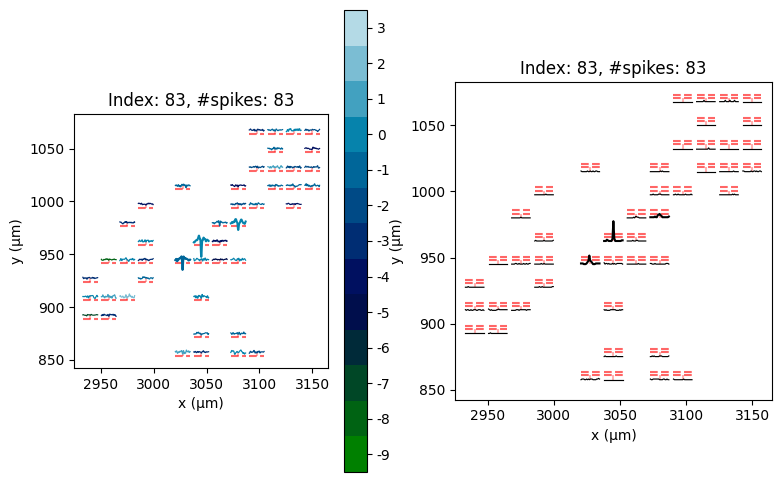

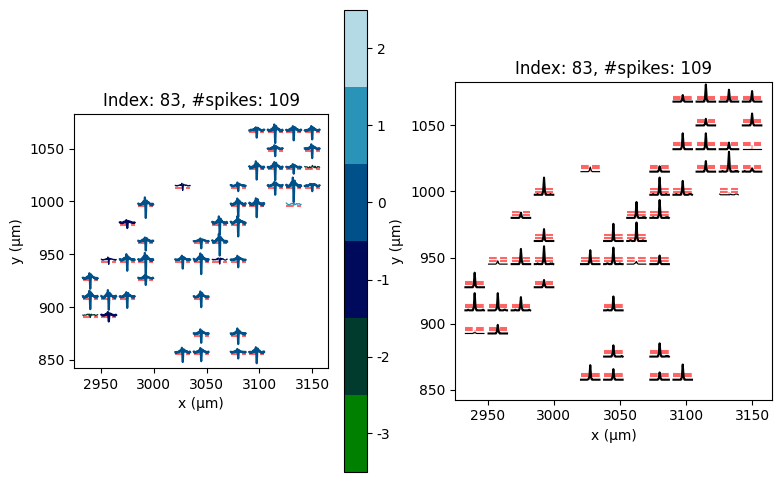

--------------------------------------------------


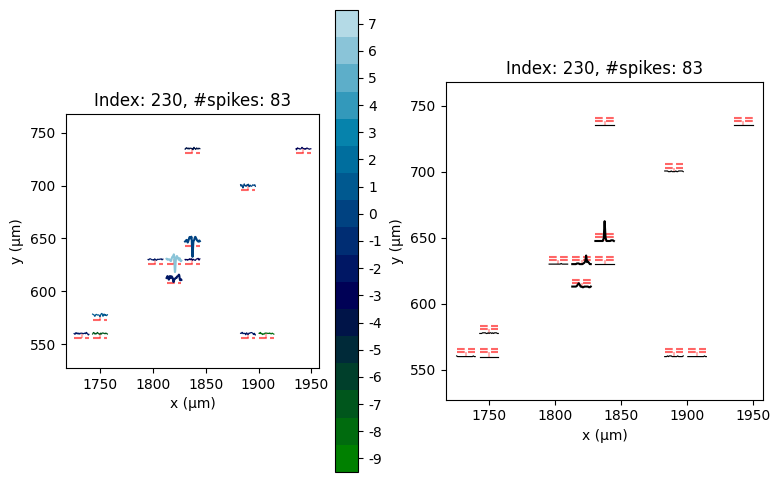

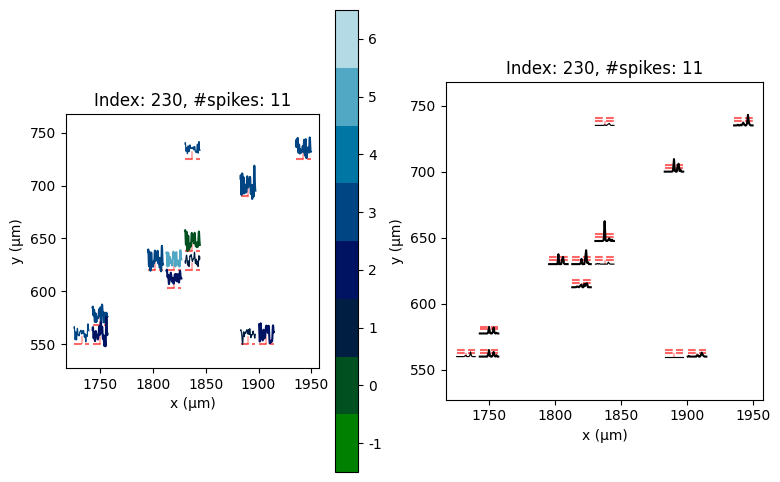

--------------------------------------------------


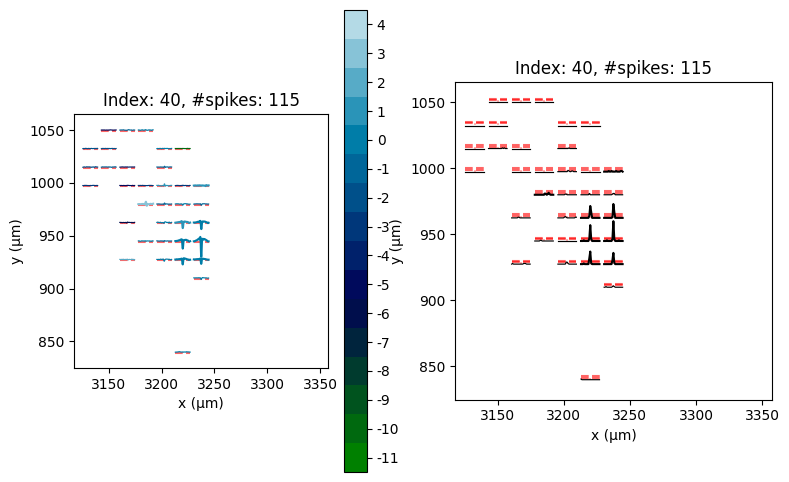

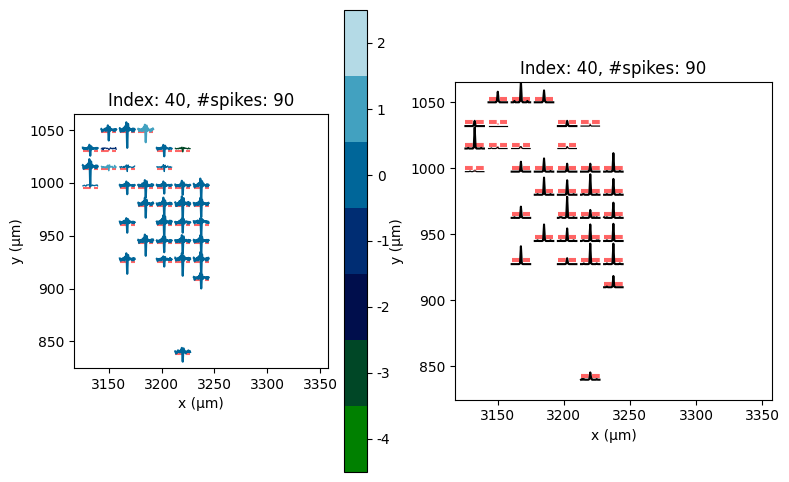

--------------------------------------------------


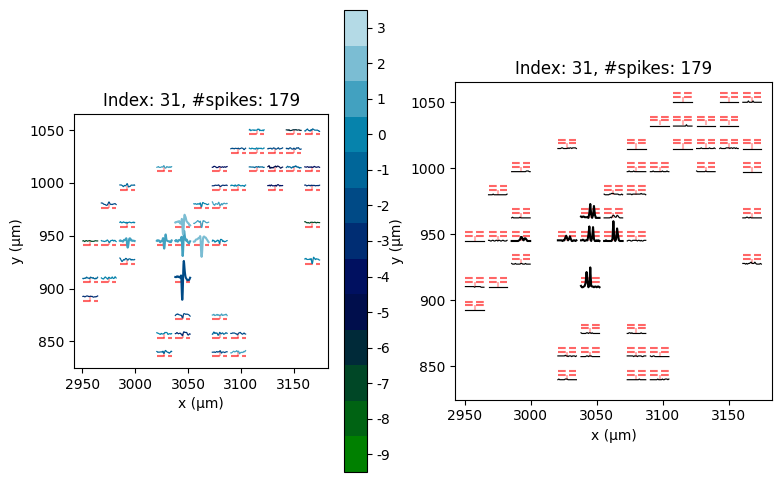

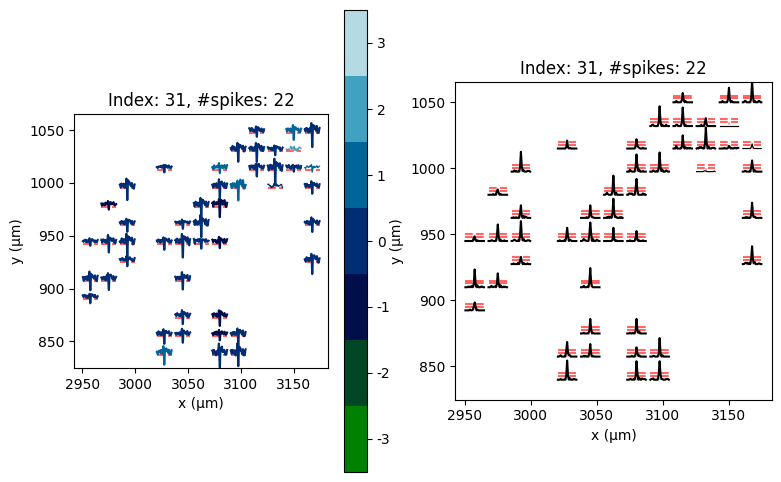

--------------------------------------------------


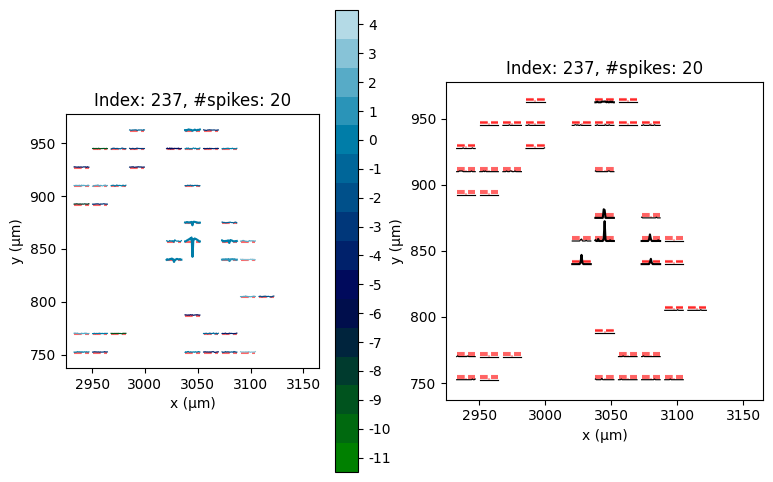

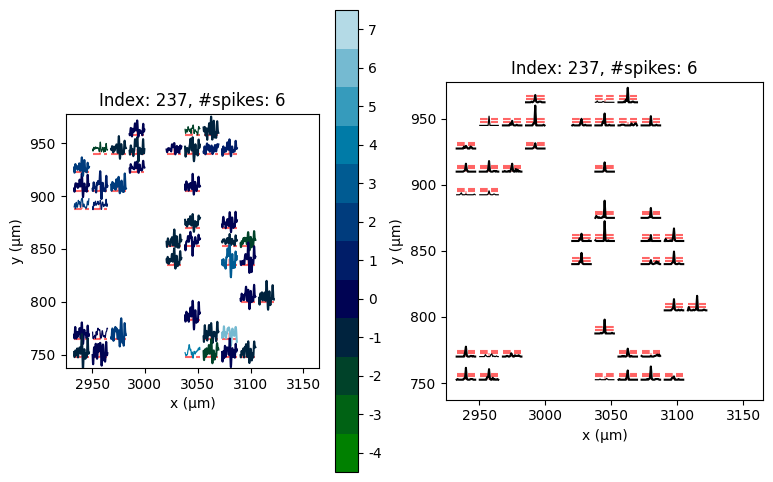

--------------------------------------------------


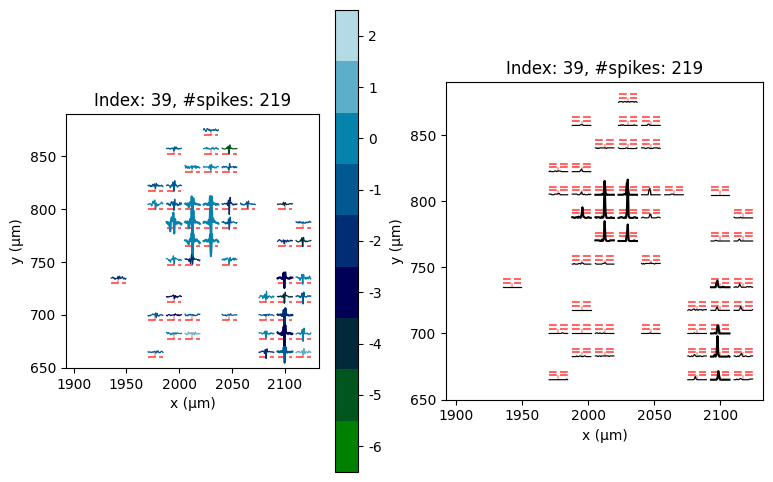

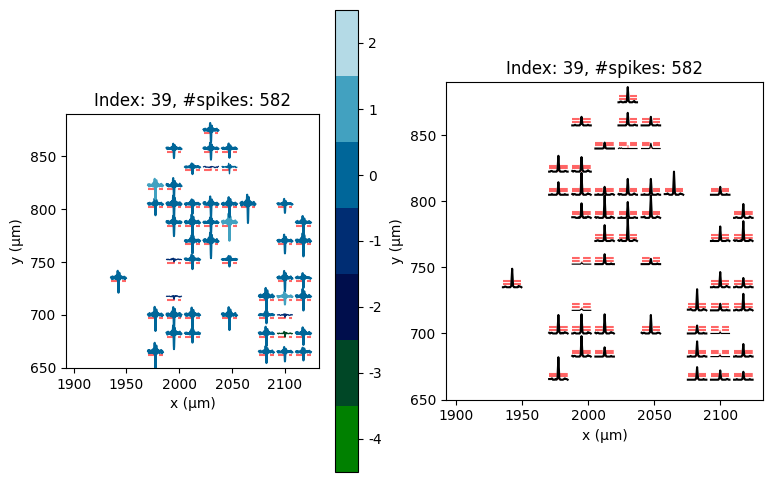

In [138]:
np.random.seed(23)
for seq in np.random.choice(final_sequences, 6):
    print("-"*50)
    
    if len(seq.spike_train) == 0:
        continue
    
    F.plot_elec_probs(seq, use_formation_spike_train=True)
    plt.show()
    
    F.plot_elec_probs(seq)
    plt.show()

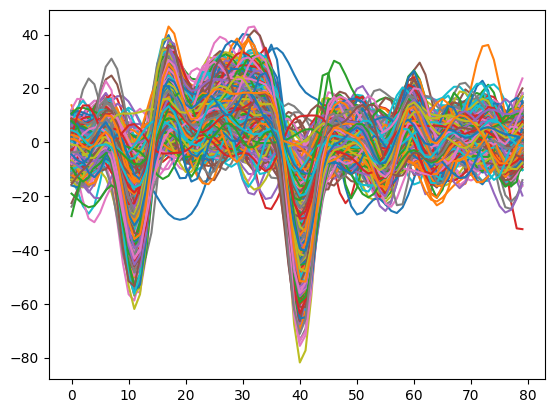

In [125]:
ms = seq.spike_train[150]
frame = round(ms * 20)
trace = TRACES_FILT[:, frame-40:frame+40]
plt.plot(trace.T)
plt.show()

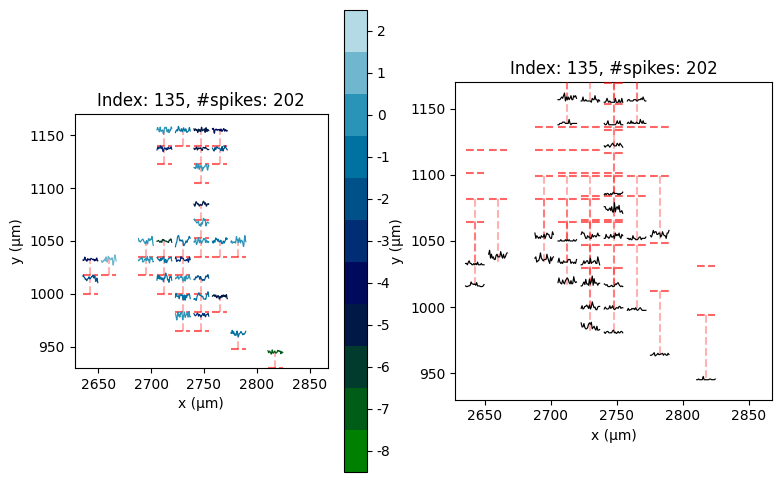

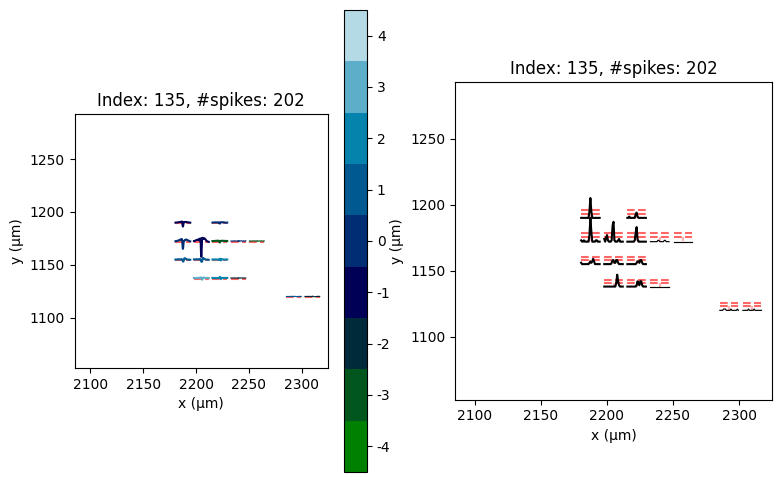

array([-118.54617   ,  -69.04051   ,  -66.21837   ,  -42.434757  ,
        -19.397211  ,  -14.872522  ,  -14.864115  ,  -13.735311  ,
        -11.792504  ,  -10.525276  ,  -10.204981  ,   -9.994837  ,
         -9.149045  ,   -9.03191   ,   -8.501145  ,   -8.451072  ,
         -7.583854  ,   -6.995183  ,   -6.027594  ,   -5.708462  ,
         -5.112551  ,   -4.917579  ,   -4.66148   ,   -4.3868995 ,
         -4.365604  ,   -4.346642  ,   -3.8165433 ,   -3.7872612 ,
         -3.7307024 ,   -3.6745727 ,   -3.6571412 ,   -3.6218157 ,
         -3.5935295 ,   -3.5834608 ,   -3.5241153 ,   -3.4177864 ,
         -3.4122782 ,   -3.4112055 ,   -3.4069629 ,   -3.3894799 ,
         -3.3874588 ,   -3.3797822 ,   -3.351155  ,   -3.3420875 ,
         -3.3248632 ,   -3.3078392 ,   -3.2974014 ,   -3.2883067 ,
         -3.2799952 ,   -3.2633922 ,   -3.2528577 ,   -3.2522802 ,
         -3.2400994 ,   -3.2285416 ,   -3.2089338 ,   -3.1949608 ,
         -3.1948833 ,   -3.1867025 ,   -3.1849484 ,   -3.15452

In [153]:
unit = units[135]

spike_train = np.array(unit["spike_train"]) / 20

chan = np.argsort(np.min(unit["template"], axis=0))[0]
F.plot_spikes(spike_train, chan, idx=unit["idx"])
plt.show()

chan = np.argsort(np.min(unit["template"], axis=0))[1]
F.plot_spikes(spike_train, chan, idx=unit["idx"])
plt.show()

amps = np.min(unit["template"], axis=0)
np.sort(amps)

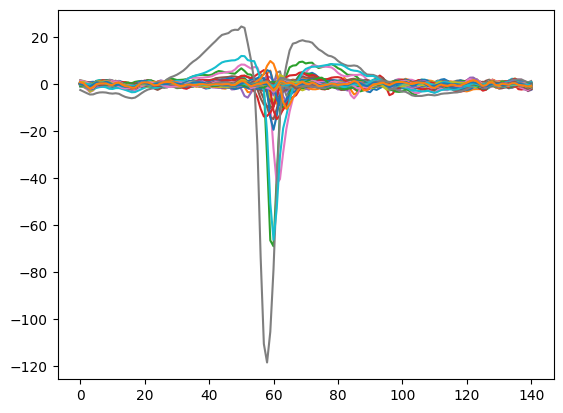

array([2747.5, 1050. ])

In [156]:
plt.plot(unit["template"])
plt.show()

order = np.argsort(np.min(unit["template"], axis=0))
ELEC_LOCS[order[0]]


--------------------------------------------------


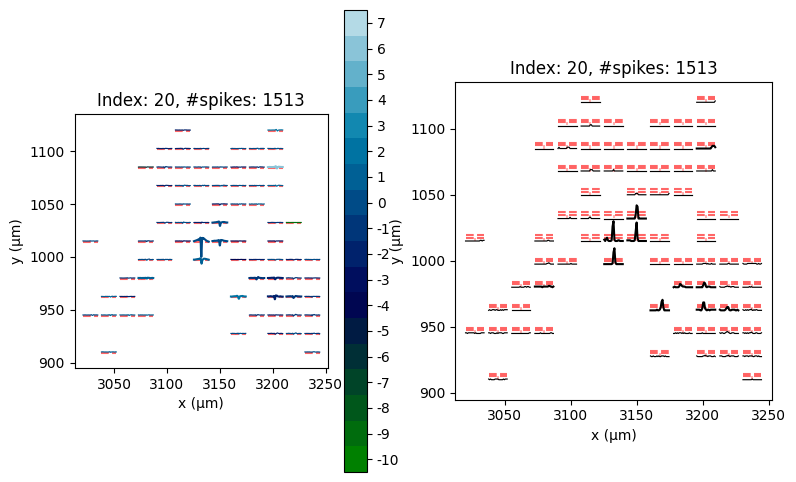

--------------------------------------------------


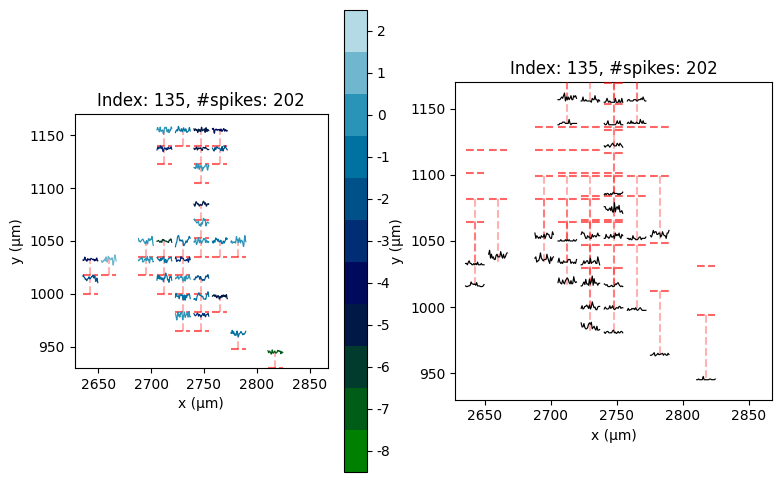

--------------------------------------------------
--------------------------------------------------


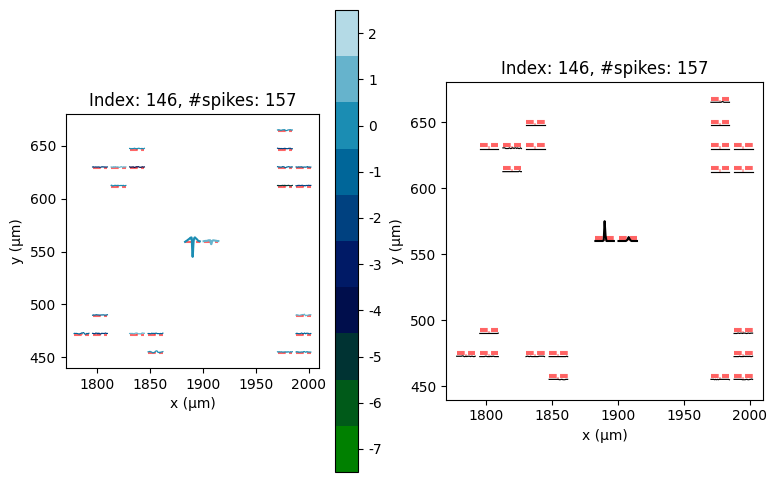

--------------------------------------------------


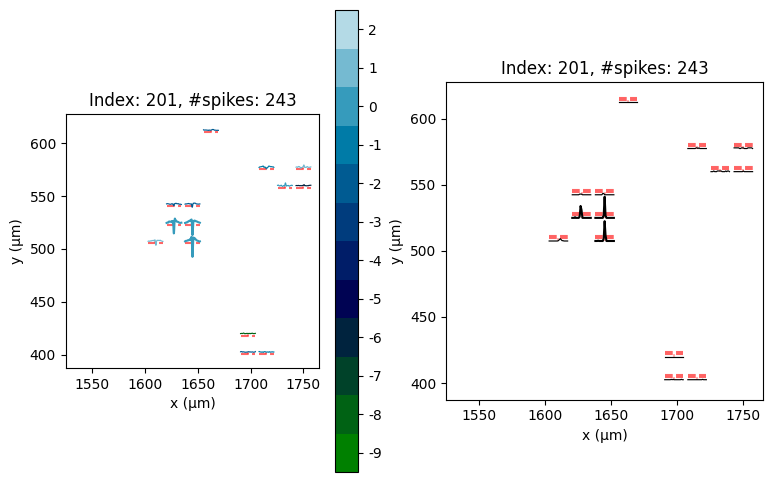

--------------------------------------------------


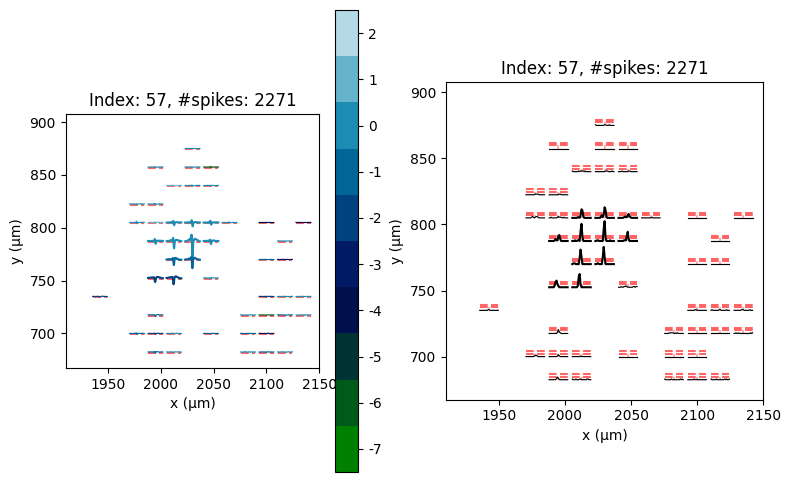

--------------------------------------------------


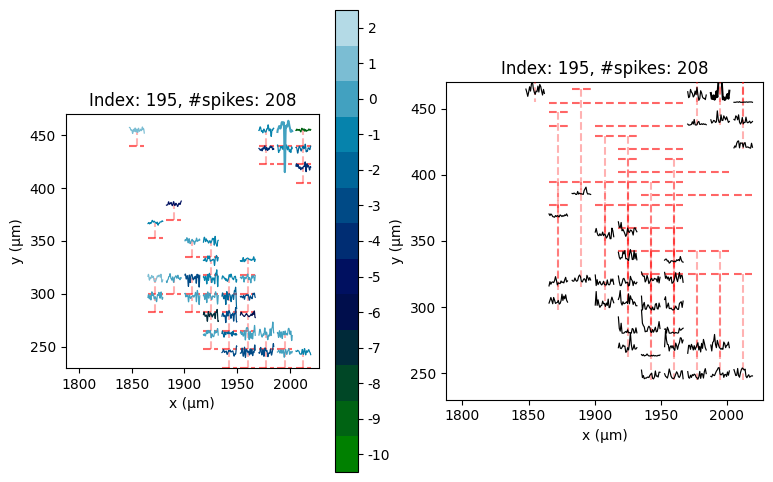

--------------------------------------------------
--------------------------------------------------


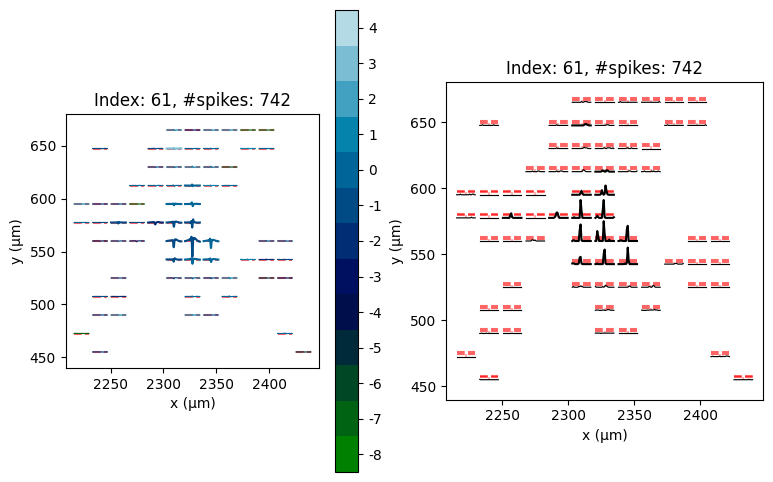

--------------------------------------------------


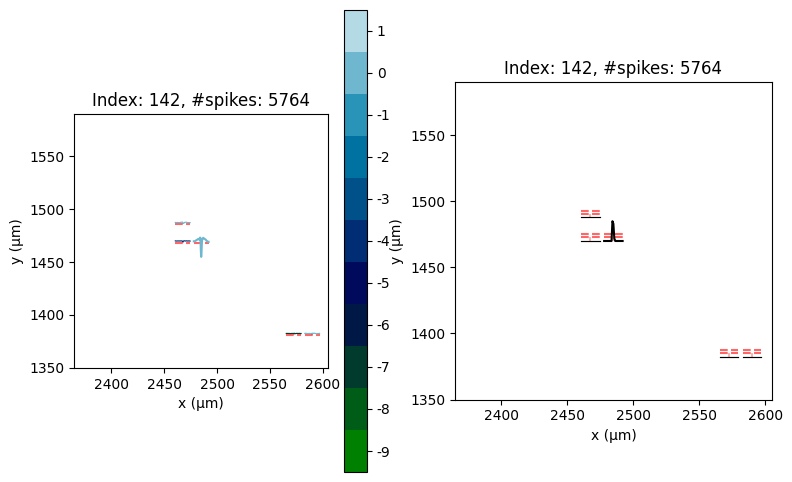

In [157]:
# Kilosort pre recording
npz = np.load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/spikesort/results/chunk0/sorted.npz", allow_pickle=True)
units = npz["units"]
for idx, unit in enumerate(units):
    unit["idx"] = idx

np.random.seed(33)
for unit in np.random.choice(units, 10):
    print("-"*50)
    
    spike_train = np.array(unit["spike_train"]) / 20
    if len(spike_train) < 10:
        continue
    
    chan = np.argsort(np.min(unit["template"], axis=0))[0]
    F.plot_spikes(spike_train, chan, idx=unit["idx"])
    plt.show()
    
    # chan = np.argsort(np.min(unit["template"], axis=0))[1]
    # F.plot_spikes(spike_train, chan, idx=unit["idx"])
    # plt.show()

In [162]:
# Kilosort patch clamps

npz = np.load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/spikesort/results/chunk1/sorted.npz", allow_pickle=True)
units = npz["units"]
for idx, unit in enumerate(units):
    unit["spike_train"] = list(unit["spike_train"] + 18019800)
    unit["idx"] = idx

npz = np.load(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/spikesort/results/chunk2/sorted.npz", allow_pickle=True)
for u, unit in enumerate(npz["units"]):
    units[u]["spike_train"].extend(unit["spike_train"] + 21722600)
    
npz = np.load(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/spikesort/results/chunk3/sorted.npz", allow_pickle=True)
for u, unit in enumerate(npz["units"]):
    units[u]["spike_train"].extend(unit["spike_train"] + 25507800)

--------------------------------------------------
--------------------------------------------------


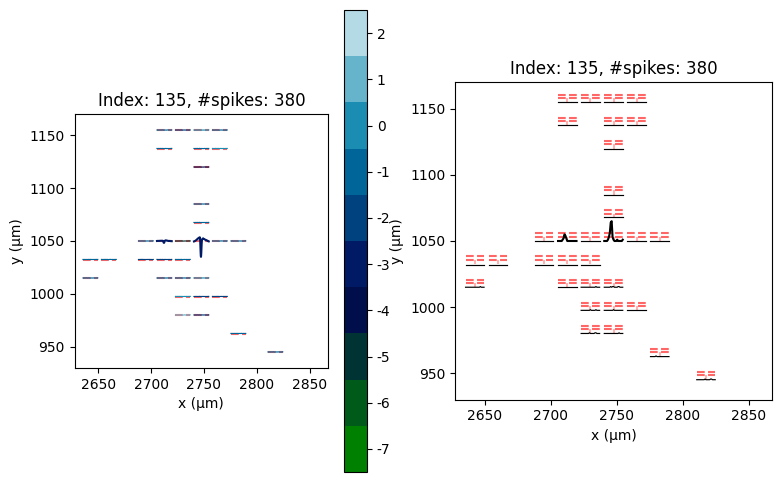

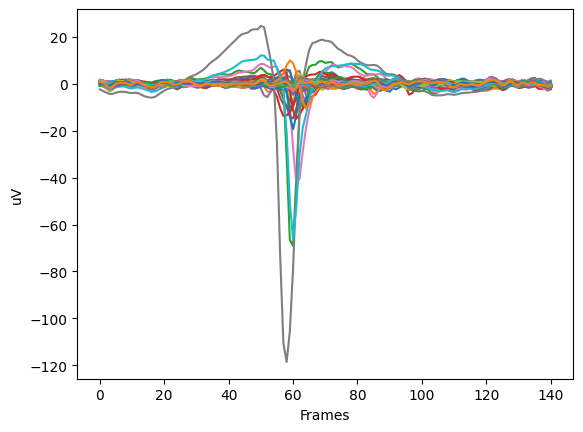

--------------------------------------------------


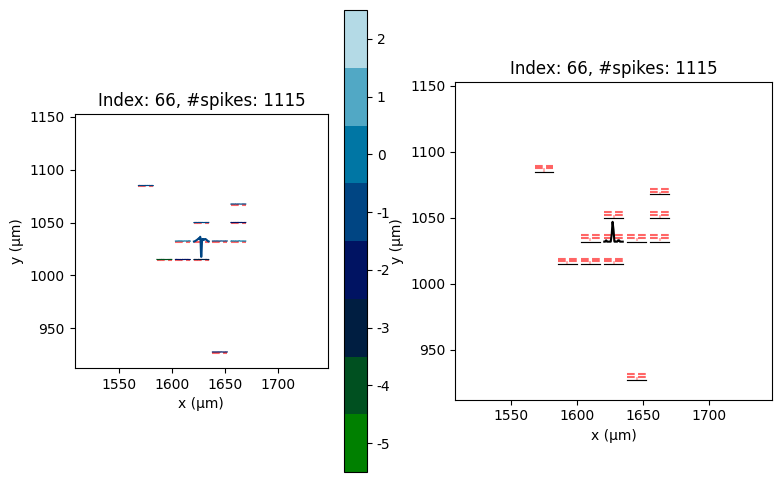

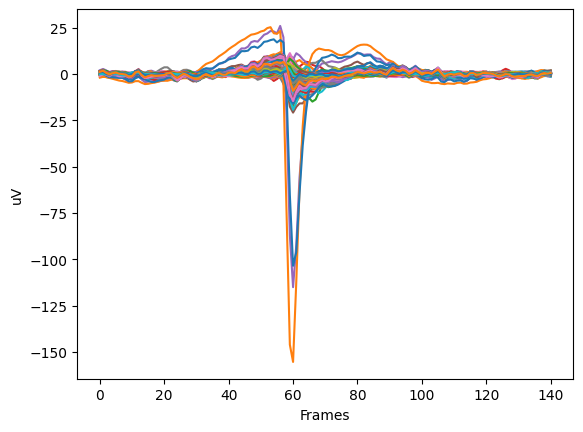

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------


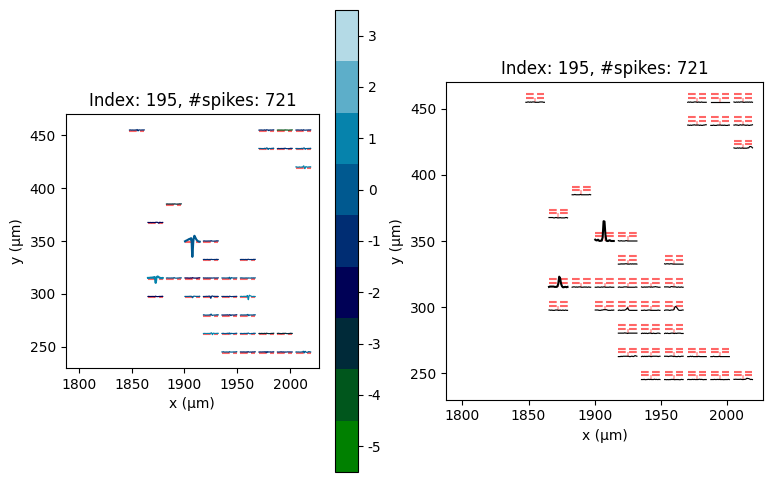

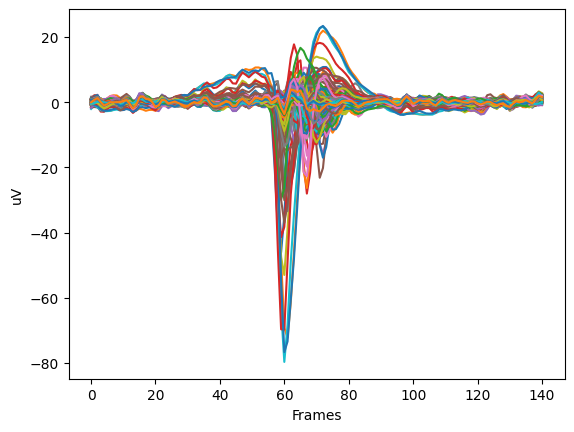

--------------------------------------------------


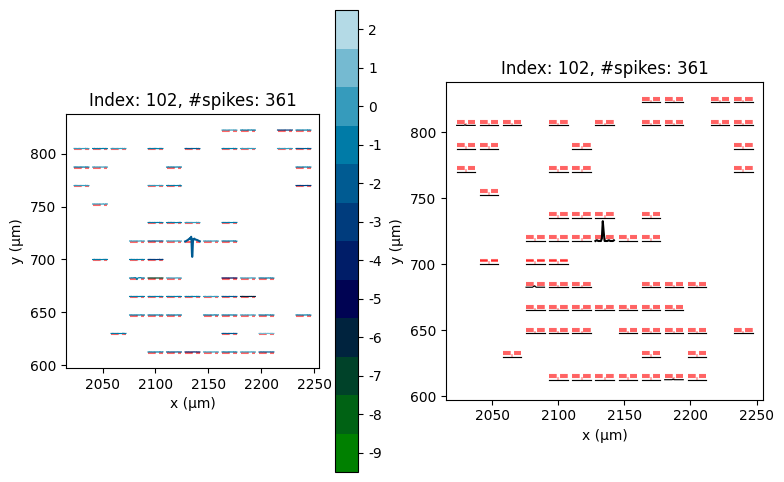

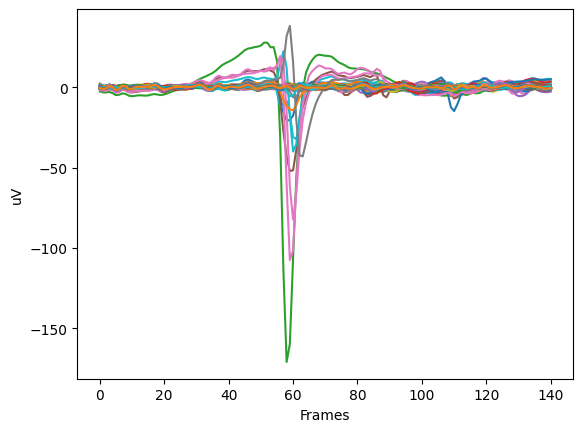

--------------------------------------------------
--------------------------------------------------


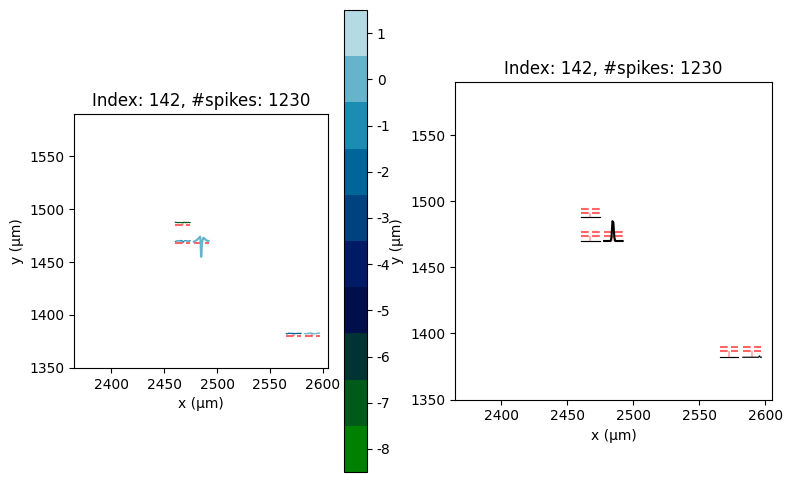

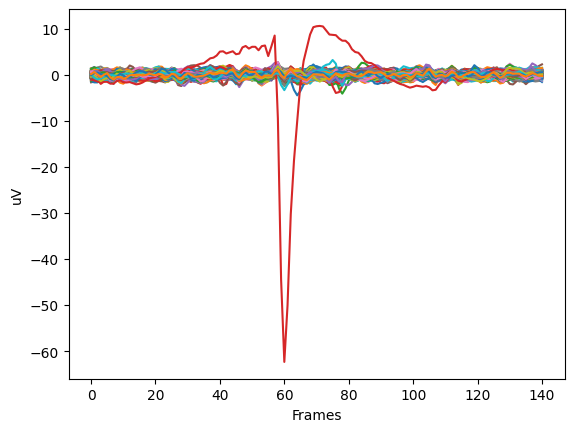

In [163]:
np.random.seed(33)
for unit in np.random.choice(units, 10):
    print("-"*50)
    
    spike_train = np.array(unit["spike_train"]) / 20
    if len(spike_train) < 10:
        continue
    
    chan = np.argsort(np.min(unit["template"], axis=0))[0]
    F.plot_spikes(spike_train, chan, idx=unit["idx"])
    plt.show()
    
    plt.plot(unit["template"])
    plt.xlabel("Frames")
    plt.ylabel("uV")
    plt.show()
    
    # chan = np.argsort(np.min(unit["template"], axis=0))[1]
    # F.plot_spikes(spike_train, chan, idx=unit["idx"])
    # plt.show()

In [129]:
count = 0
for i, unit in enumerate(units):
    print(i, len(unit["spike_train"]))
    if len(unit["spike_train"]) >= np.diff(TESTING_MS)/1000 * 0.05:
        count += 1
print(f"ks units 0.05hz: {count}")

0 0
1 1
2 0
3 0
4 0
5 2047
6 3
7 2047
8 0
9 4
10 466
11 0
12 472
13 10
14 0
15 1184
16 463
17 772
18 478
19 1181
20 0
21 2
22 3
23 3
24 361
25 2
26 1867
27 0
28 772
29 620
30 418
31 18
32 809
33 1115
34 702
35 292
36 296
37 21
38 0
39 3
40 0
41 1181
42 4
43 0
44 68
45 641
46 0
47 4
48 638
49 2678
50 0
51 138
52 0
53 1
54 466
55 0
56 770
57 0
58 555
59 0
60 0
61 1
62 0
63 2042
64 360
65 0
66 1115
67 1869
68 0
69 2042
70 770
71 0
72 229
73 12
74 2677
75 1110
76 86
77 763
78 2688
79 1210
80 770
81 256
82 5
83 111
84 642
85 4
86 3
87 222
88 557
89 297
90 746
91 1181
92 0
93 0
94 4
95 69
96 0
97 0
98 516
99 358
100 0
101 1
102 361
103 392
104 448
105 1
106 575
107 2
108 771
109 464
110 1183
111 0
112 454
113 0
114 469
115 293
116 3
117 241
118 738
119 1394
120 680
121 376
122 194
123 1
124 1295
125 1
126 153
127 1395
128 557
129 0
130 1017
131 45
132 198
133 441
134 9
135 380
136 0
137 1517
138 2
139 715
140 1399
141 0
142 1230
143 1
144 1864
145 619
146 1
147 2
148 1
149 0
150 0
151 1
152 

In [132]:
final_sequences = utils.pickle_load(ROOT_PATH / "final_sequences.pickle")  # Might need to reload sequences if error about not being able to pickle class is raised
F.save_sequences_plots([seq for seq in final_sequences if len(seq.spike_train) > 0], ROOT_PATH  / "sequence_footprints")

100%|██████████| 263/263 [02:13<00:00,  1.97it/s]


0.23076923076923078


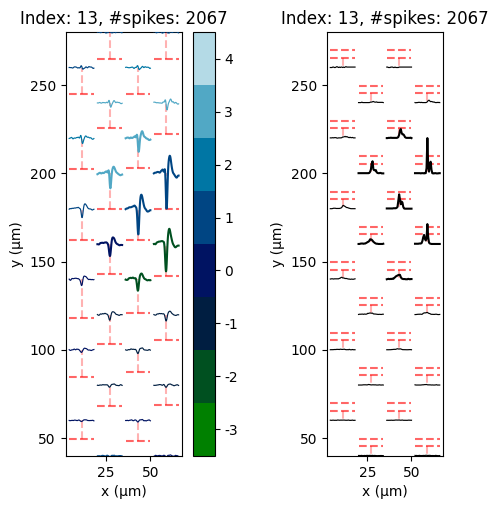

In [152]:
seq = final_sequences[13]
F.plot_elec_probs(seq)
isis = np.diff(seq.spike_train)
viols = isis <= 1.5
print(np.sum(viols) / len(seq.spike_train))

[375239.5        375239.63333333]


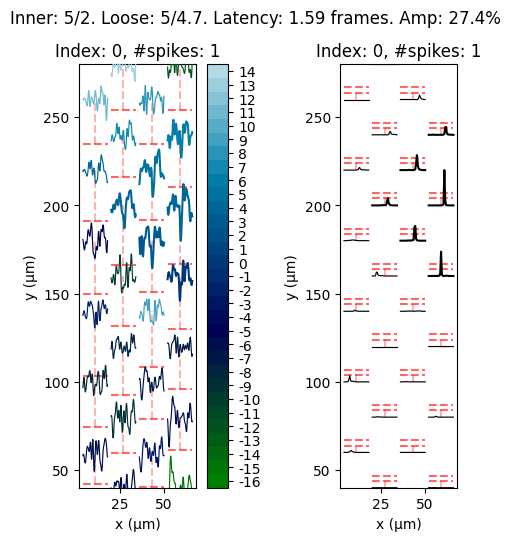

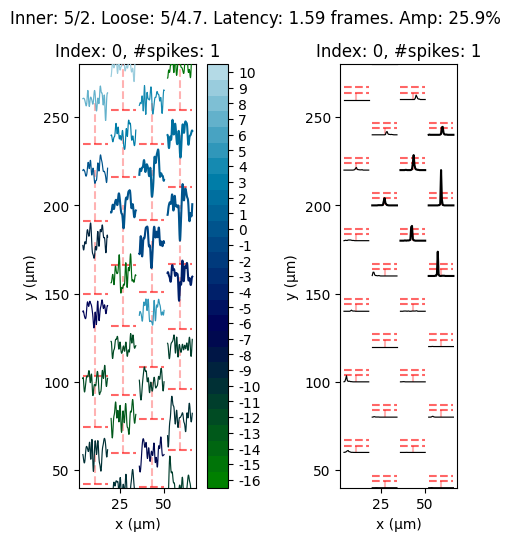

In [156]:
np.random.seed(231)
ind = np.flatnonzero(viols)
np.random.shuffle(ind)
for idx in ind:
    print(seq.spike_train[idx:idx+2])
    
    F.plot_seq_spike_overlap(seq, seq.spike_train[idx])
    plt.show()
    
    F.plot_seq_spike_overlap(seq, seq.spike_train[idx+1])
    plt.show()
    
    break

In [155]:
seq.root_elecs

[13, 17]

### Testing

In [ ]:
# For testing concatenated spike trains
# spike_times = set()
# for seq in final_sequences:
#     spike_times.update(seq._spike_train)
# spike_times = np.sort(list(spike_times))
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231128/overlap_time_0.0_no_interelec.npy", spike_times)

# utils.pickle_dump(final_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231128/final_sequences_test_0.0.pickle")
# final_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231128/final_sequences_test.pickle")

In [ ]:
# for idx in [170, 179, 180, 181, 183, 186, 190, 189, 191, 187]:
#     F.plot_elec_probs(all_sequences[idx])
#     plt.show()

cluster_i = all_sequences[170]
cluster_j = all_sequences[180]

F.plot_elec_probs(cluster_i)
plt.show()

F.plot_elec_probs(cluster_j)
plt.show()

elecs = cluster_i.elecs
                
# Compare latencies
elec_weights = F.get_elec_weights(cluster_i.elec_probs, cluster_j.all_elec_probs[elecs], for_latencies=True)
latency_diff = np.sum(np.abs(cluster_i.latencies - cluster_j.all_latencies[elecs[1:]]) * elec_weights)
print(latency_diff)

elec_weights = F.get_elec_weights(cluster_i.elec_probs, cluster_j.all_elec_probs[elecs], for_latencies=False)
cluster_j_amp_medians = cluster_j.all_amp_medians[elecs]
amp_median_div = (cluster_i.amp_medians + cluster_j_amp_medians) / 2
amp_median_diff = np.abs((cluster_i.amp_medians - cluster_j_amp_medians)) / amp_median_div
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(amp_median_diff)

0.8140128363575329
0.20346771


### Manual threshold tuning

In [ ]:
MAX_LATENCY_DIFF = 2.51
MAX_AMP_MEDIAN_DIFF = 0.35
MIN_INNER_COCS = 0
MIN_OUTER_COCS = 0

MIN_SPIKES = 0.05 * 300 # Based on HZ

def job(root_elec):
    merges = F.form_from_root(root_elec, TRAINING_FRAMES,
                  max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                  min_inner_cocs=MIN_INNER_COCS, min_outer_cocs=MIN_OUTER_COCS)
    return merges


for inner, outer in [(0, 0), (1, 2), (1, 3), (2, 3), (2, 4)]:
    MIN_INNER_COCS = inner
    MIN_OUTER_COCS = outer
  
    try:
        all_sequences = []
        with Pool(processes=20) as pool:
            for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
                all_sequences += sequences
        for idx, seq in enumerate(all_sequences):
            seq.idx = idx
        all_sequences_before_inter = deepcopy(all_sequences)
        print(f"{len(all_sequences)} sequences before interelec merging")
            
        try:  
            all_sequences = F.merge_coc_clusters(all_sequences, max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                                                auto_setup_coc_clusters=False, verbose=True)
            final_sequences = []
            idx = 0
            for seq in all_sequences:
                if len(seq._spike_train) >= MIN_SPIKES:
                    seq.idx = idx
                    final_sequences.append(seq)
                    idx += 1
            print(f"{len(final_sequences)} sequences after interelec merging")
        
            F.assign_spikes(final_sequences, TESTING_FRAMES, interelec=True, only_max_amps=False,
                            max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                            min_inner_cocs=MIN_INNER_COCS, min_outer_cocs=MIN_OUTER_COCS, 
                            verbose=True)
            addon = ""
        except:
            final_sequences = all_sequences_before_inter
            addon = "_before_interelec_merging"
    
        F.save_sequences_plots(final_sequences, Path(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231127/{inner}_{outer}{addon}"))
    except:
        pass

# all_sequences = []
# with Pool(processes=20) as pool:
#     for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
#         all_sequences += sequences
# all_sequences = F.merge_coc_clusters(all_sequences, max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
#                                      auto_setup_coc_clusters=False)
# final_sequences = []
# idx = 0
# for seq in all_sequences:
#     if len(seq._spike_train) >= MIN_SPIKES:
#         seq.idx = idx
#         final_sequences.append(seq)
#         idx += 1

# F.assign_spikes(final_sequences, TESTING_FRAMES, interelec=True, only_max_amps=False,
#                 max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
#                   min_inner_cocs=MIN_INNER_COCS, min_outer_cocs=MIN_OUTER_COCS)


# F.save_sequences_plots(final_sequences, )


# Because using imap (instead of imap_unordered), the progress bar freezes (for elecs with many cocs/clusters)
# it then jumps rapidly to the end 

In [ ]:
F.save_sequences_plots(all_sequences, Path(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231127/{inner}_{outer}"))


In [ ]:
all_sequences = F.clusters_to_clusters(all_sequences)

In [ ]:
# utils.pickle_dump(all_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_sequences_dip_test.pickle")
all_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_sequences_dip_test.pickle")    
# all_sequences = F.setup_coc_clusters_parallel(all_sequences)

In [ ]:
all_spike_times_curated = []
for seq in all_sequences:
    all_spike_times_curated.extend(seq.spike_train)
all_spike_times_curated = np.sort(all_spike_times_curated)

matches = Comparison.count_matching_events(all_spike_times_curated, ks_spikes)
print(f"#matches/#rt_sort: {matches/len(all_spike_times_curated)*100:.1f}")
print(f"#matches/#kilosort: {matches/len(ks_spikes)*100:.1f}")

#matches/#rt_sort: 46.2
#matches/#kilosort: 87.8


In [ ]:
all_merged_sequences = F.merge_coc_clusters(all_sequences, max_root_elec_dist=50,
                                            auto_setup_coc_clusters=False,
                                            verbose=True)


Merged 140 with 143
Latency diff: 0.03. Rel amp diff: 0.00
Amp dist p-value 0.9544
#spikes:
Merge base: 2341, Add: 2184, Overlaps: 1
After merging: 2397

Merged 119 with 122
Latency diff: 0.14. Rel amp diff: 0.01
Amp dist p-value 1.0000
#spikes:
Merge base: 3087, Add: 3193, Overlaps: 0
After merging: 3317

Merged 272 with 275
Latency diff: 0.07. Rel amp diff: 0.02
Amp dist p-value 1.0000
#spikes:
Merge base: 1747, Add: 2823, Overlaps: 460
After merging: 3277

Merged 134 with 138
Latency diff: 0.13. Rel amp diff: 0.03
Amp dist p-value 0.8204
#spikes:
Merge base: 677, Add: 559, Overlaps: 9
After merging: 1029

Merged 283 with 286
Latency diff: 0.00. Rel amp diff: 0.06
Amp dist p-value 0.9942
#spikes:
Merge base: 2617, Add: 1256, Overlaps: 74
After merging: 2760

Merged 171 with 176
Latency diff: 0.11. Rel amp diff: 0.05
Amp dist p-value 0.9964
#spikes:
Merge base: 3158, Add: 1585, Overlaps: 5
After merging: 3557

Merged 218 with 222
Latency diff: 0.00. Rel amp diff: 0.07
Amp dist p-valu

In [ ]:
# utils.pickle_dump(all_merged_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_merged_sequences_dip_test.pickle")

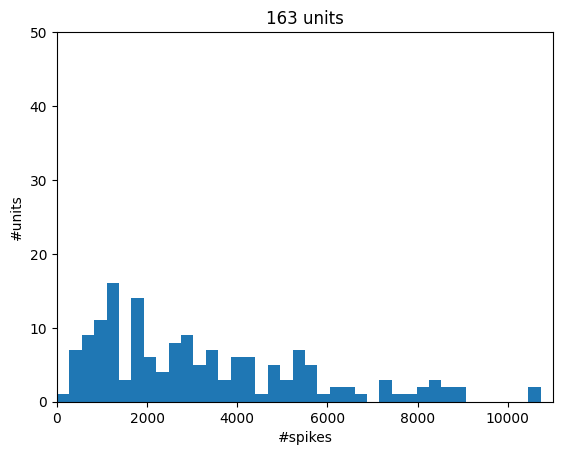

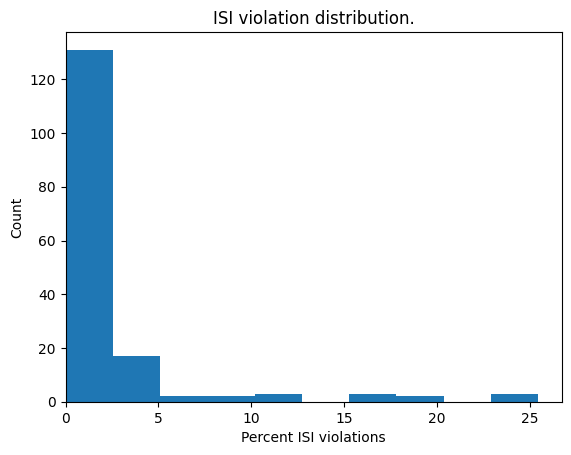

In [ ]:
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.plot_nums_spikes()
plt.show()
prop_signal.plot_isis()
plt.show()

100%|██████████| 163/163 [00:09<00:00, 16.92it/s]


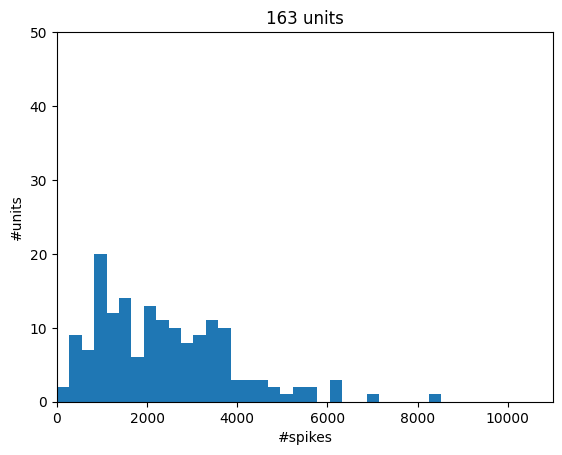

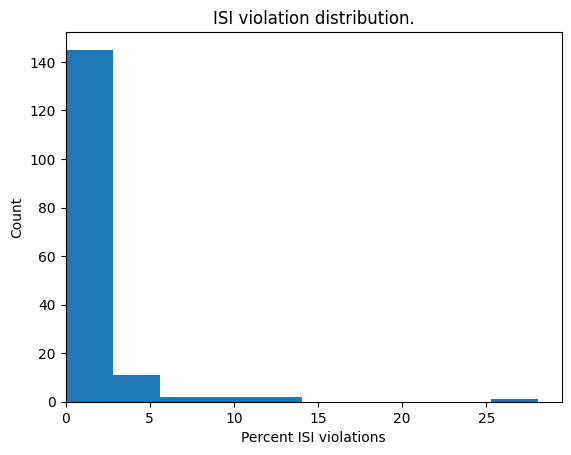

In [ ]:
# This probably isn't needed (maybe it is though)
F.assign_spikes(all_merged_sequences, TRAINING_FRAMES, interelec=True,
                overlap_time=0.1, verbose=True)
all_merged_sequences = F.setup_coc_clusters_parallel(F.clusters_to_clusters(all_merged_sequences))
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.plot_nums_spikes()
plt.show()
prop_signal.plot_isis()
plt.show()

### Further development

In [ ]:
for s, seq in enumerate(all_trained_sequences):
    # If seq is Unit obj
    seq.recording = RECORDING
    seq.root_elecs = [seq.chan]
    seq._spike_train = seq.spike_train
    
    isi = F.get_isi_viol_p(seq)
    if isi > 20:
        print(s)
        
        F.plot_elec_probs(seq, idx=s)
        plt.show()
        
        F.plot_amp_dist(seq, bins=40)
        plt.show()
        
        print(F.get_isi_viol_p(seq))

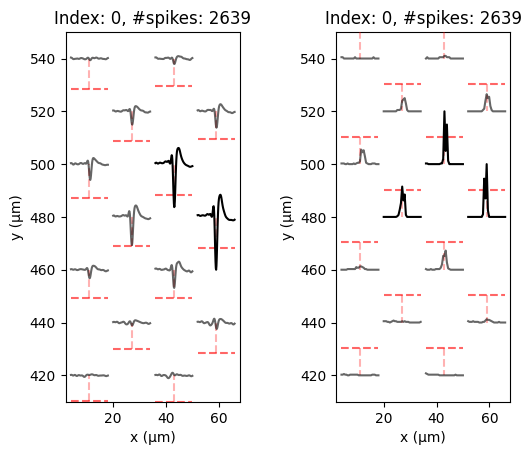

2630


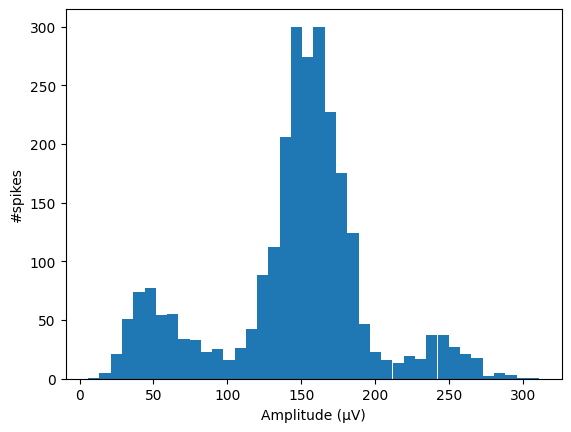

31.527093596059114


In [ ]:
isi_violators = [cluster for cluster in all_trained_sequences if F.get_isi_viol_p(cluster) > 2]
for s, cluster in enumerate(isi_violators):
    if F.get_isi_viol_p(cluster) > 30:
        F.plot_elec_probs(cluster)
        plt.show()
        
        F.plot_amp_dist(cluster, bins=40)
        plt.show()
        
        print(F.get_isi_viol_p(cluster))
        
        break


In [ ]:
for idx in cluster.merge_history:
    clust = all_sequences[idx]
    F.plot_split_amp(clust, 100)
        
    # F.plot_elec_probs(clust)
    # plt.show()
    # F.plot_amp_dist(clust, bins=40)
    # plt.show()
    # print(F.get_isi_viol_p(clust))
    break

## Assign spikes in test region

In [ ]:
F.assign_spikes(all_merged_sequences, TESTING_FRAMES, interelec=True,
                overlap_time=0.1,
                verbose=True)

100%|██████████| 2227701/2227701 [07:54<00:00, 4696.73it/s]


### Further development

In [ ]:
for s, seq in enumerate(all_merged_sequences):
    # If seq is Unit obj
    # seq.recording = RECORDING
    # seq.root_elecs = [seq.chan]
    # seq._spike_train = seq.spike_train
    
    isi = F.get_isi_viol_p(seq)
    if isi > 2:
        isis = np.diff(seq.spike_train)
        plt.hist(isis, bins=40, range=(0, 5))
        plt.xlim(0, 5)
        plt.show()
        
        
        
        # F.plot_elec_probs(seq, idx=s)
        # plt.show()
        
        # F.plot_amp_dist(seq, bins=40)
        # plt.show()
        
        # print(F.get_isi_viol_p(seq))

In [ ]:
for seq in all_merged_sequences:
    F.plot_elec_probs(seq)
    plt.show()

## Save to file

In [ ]:
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/2.pickle")

In [ ]:
# quick and dirty, find #overlaps
OVERLAP_TIME = 0.034

all_spikes = []
for s in all_trained_sequences:
    all_spikes.extend(s.spike_train)
all_spikes = np.sort(all_spikes)

count = 0
for i in range(1, len(all_spikes)):
    if all_spikes[i] - all_spikes[i-1] <= OVERLAP_TIME:
        count += 1
print(count)
print(count / len(all_spikes) * 100)

25042
6.761839699953827


## Compare to kilosort
For development and testing

### Setup

In [ ]:
%autoreload 2
from src.comparison import Comparison
from src.sorters.base import SpikeSorter
from src.sorters.kilosort import get_experts_kilosort

In [ ]:
kilosort = get_experts_kilosort(testing_ms=TESTING_FRAMES)

# Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.templates = templates
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    unit.root_elecs = [unit.chan]
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)
        
chan_to_ks_units = {}
for unit in all_ks_units:
    if unit.chan not in chan_to_ks_units:
        chan_to_ks_units[unit.chan] = [unit]
    else:
        chan_to_ks_units[unit.chan].append(unit)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array([spikes1[idx] for idx in range(len(comp.match12)) if comp.match12[idx] != -1])


Recording does not have scaled traces. Setting gain to 0.195


100%|██████████| 226/226 [05:07<00:00,  1.36s/it]


In [ ]:
chan_to_prop_units = {}
for unit in final_sequences:
    for chan in unit.root_elecs:
        if chan not in chan_to_prop_units:
            chan_to_prop_units[chan] = [unit]
        else:
            chan_to_prop_units[chan].append(unit)

### Start comparing

In [ ]:
CHAN = 17

prop_units = chan_to_prop_units[CHAN]
ks_units = chan_to_ks_units[CHAN]
##
print(len(prop_units))
print(len(ks_units))

3
4


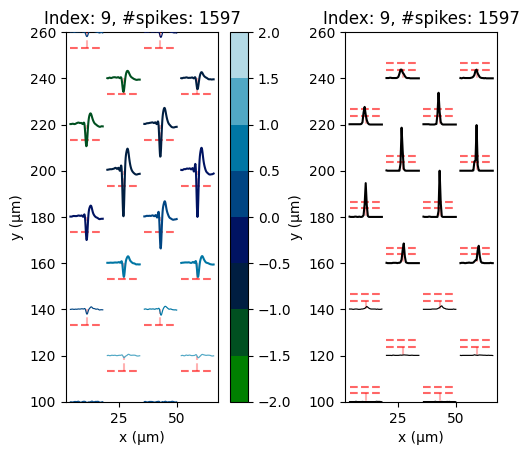

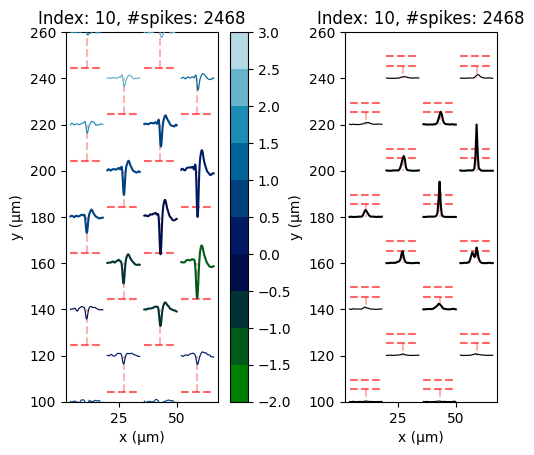

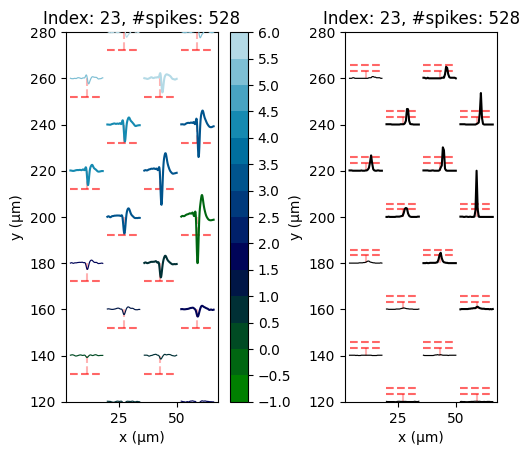

In [ ]:
for unit in prop_units:   
    amp_kwargs, prob_kwargs = F.plot_elec_probs(unit)#, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

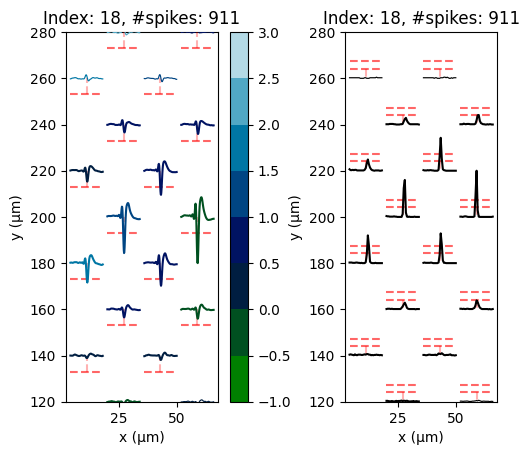

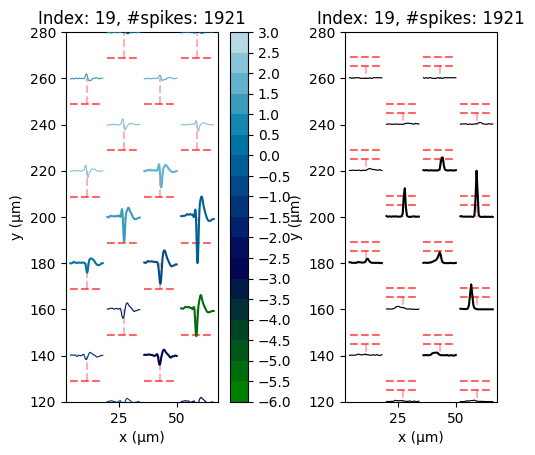

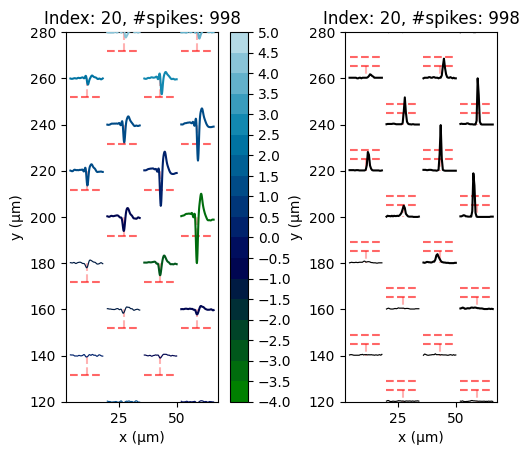

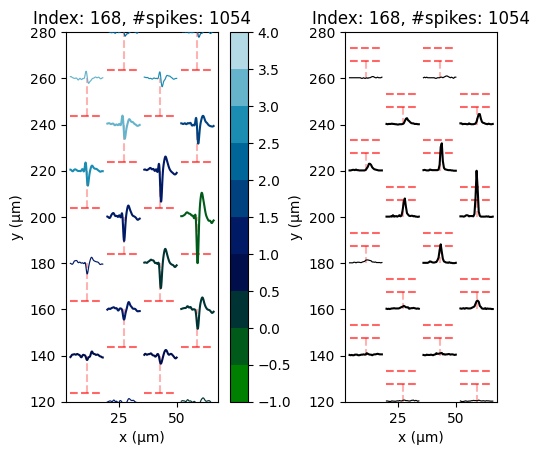

In [ ]:
for unit in ks_units:   
    amp_kwargs, prob_kwargs = F.plot_elec_probs(unit)#, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

In [ ]:
all_prop_spikes = set()
for unit in final_sequences:
    all_prop_spikes.update(unit._spike_train)
all_prop_spikes = np.sort(list(all_prop_spikes))

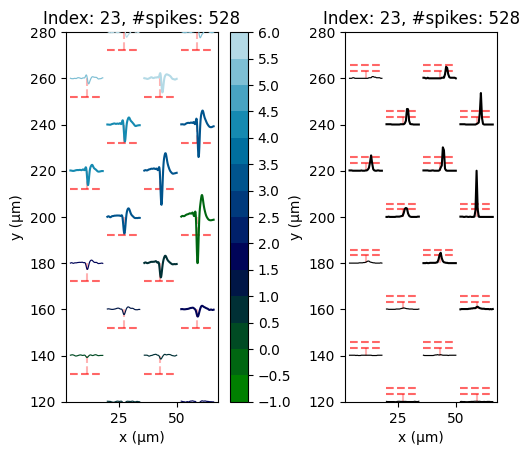

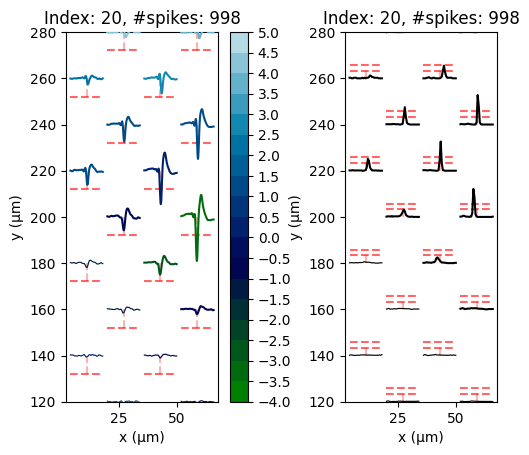

In [ ]:
prop_unit = sequence = prop_units[2]
ks_unit = ks_units[2]

amp_kwargs, prob_kwargs = F.plot_elec_probs(prop_unit)
plt.show()

F.plot_elec_probs(ks_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

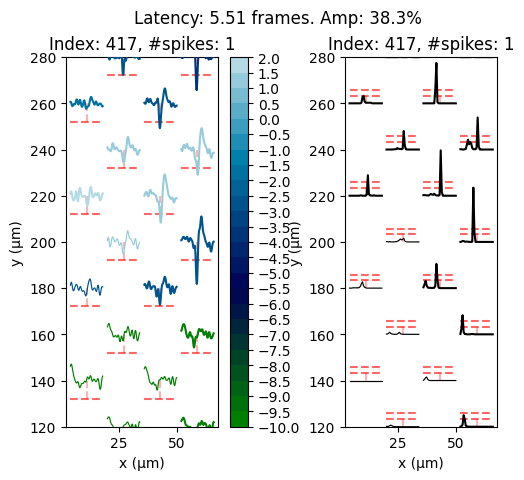

In [ ]:
np.random.seed(10)

# for spike_idx in np.random.choice(len(ks_unit.spike_train), 20, replace=False):
for spike_idx in [417]:
    time = ks_unit.spike_train[spike_idx]    

    # Check if prop detected spike
    if np.any(np.abs(all_prop_spikes - time) <= 0.4): 
        continue
    
    unit = Unit(spike_idx, [time], ks_unit.chan, RECORDING)
    F.plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    
    # region Set latency and amp diff scores in title
    n_before = n_after = 15 # 10 
    
    elecs = [unit.chan] + F.get_nearby_elecs(unit.chan)
    
    output_frame = F.rec_ms_to_output_frame(time)
    this_n_before = n_before if output_frame - n_before >= 0 else output_frame  # Prevents indexing problems
    output_window = F.OUTPUTS[:, output_frame-this_n_before:output_frame+n_after+1]
    all_elec_probs = F.sigmoid(np.max(output_window, axis=1))
    
    output_window = output_window[elecs]
    elec_probs = F.sigmoid(np.max(output_window, axis=1))
    
    latencies = np.argmax(output_window, axis=1) - this_n_before 
    
    rec_frame = round(time * SAMP_FREQ)
    amps = np.abs(F.TRACES[elecs, rec_frame + latencies])
    window_medians = F.calc_window_medians(time, elecs)  #  NOTE: This might be really slow, might be better to cache and update every X ms
    amp_medians = amps / window_medians
    
    latencies = latencies[1:]
    
    unit_elec_probs, unit_latencies, unit_amp_medians = sequence.all_elec_probs[elecs], sequence.all_latencies[elecs[1:]], sequence.all_amp_medians[elecs]
    
    elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=True)
    latency_diff = np.sum(np.abs(unit_latencies - latencies) * elec_weights)
    
    elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=False)
    amp_median_div = (unit_amp_medians + amp_medians) / 2
    amp_median_diff = np.abs((unit_amp_medians - amp_medians)) / amp_median_div
    amp_median_diff = np.sum(amp_median_diff * elec_weights)
    
    plt.suptitle(f"Latency: {latency_diff:.2f} frames. Amp: {amp_median_diff*100:.1f}%")
    
    plt.show()
    # endregion

In [ ]:
unit_elec_probs

array([0.6081915 , 0.58287376, 0.26068977, 0.3001964 , 0.58387554,
       0.11380184, 0.3526624 , 0.06465013, 0.07087522, 0.3260975 ,
       0.22613387, 0.05174522, 0.05917944, 0.03786819, 0.04209668,
       0.04788675, 0.04545609, 0.04759733], dtype=float32)

In [ ]:
elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=True)
latency_diff = np.sum(np.abs(unit_latencies - latencies) * elec_weights)

for elec, weight, unit_latency, latency in zip(elecs[1:], elec_weights, unit_latencies, latencies):
    print(f"{elec}: {unit_latency:.2f}, {latency:.2f}, {weight*100:.1f}%, {np.abs(unit_latency - latency)*weight*100:.1f}%")

19: 2.98, 1.00, 16.0%, 31.7%
15: 0.30, -3.00, 7.9%, 26.0%
18: 3.03, 1.00, 4.7%, 9.6%
21: 3.69, 1.00, 13.6%, 36.7%
13: 0.60, -13.00, 4.9%, 67.2%
22: 4.15, 1.00, 8.1%, 25.4%
14: 0.94, -12.00, 1.2%, 16.0%
16: 2.03, -3.00, 2.1%, 10.6%
20: 4.34, 2.00, 8.1%, 18.9%
23: 6.06, -3.00, 10.2%, 92.8%
11: 0.57, -12.00, 1.3%, 16.4%
24: 4.71, -2.00, 2.2%, 14.6%
12: 0.99, -12.00, 0.0%, 0.0%
9: 0.57, -12.00, 2.6%, 33.2%
25: 5.40, -4.00, 11.2%, 104.9%
26: 4.35, -3.00, 4.9%, 35.9%
10: 0.73, -11.00, 0.9%, 10.9%


In [ ]:
elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=False)
amp_median_div = (unit_amp_medians + amp_medians) / 2
amp_median_diff = np.abs((unit_amp_medians - amp_medians)) / amp_median_div
print(amp_median_diff[0])
print(amp_median_diff)
print(np.sum(amp_median_diff * elec_weights))

0.09285006
[0.09285006 0.01739845 0.42813304 0.26943627 0.29808164 1.0423726
 0.30952084 1.1683204  0.51168346 0.4498598  0.9677229  0.959181
 0.10201103 0.545433   1.1859486  1.3195163  1.0869895  0.8530344 ]
0.5253458


In [ ]:
elecs

[17, 19, 15, 18, 21, 13, 22, 14, 16, 20, 23, 11, 24, 12, 9, 25, 26, 10]

In [ ]:
unit_amp_medians

array([13.765633 ,  9.400559 ,  4.7808948,  4.7514014,  8.544403 ,
        3.2067585,  4.3976264,  2.1040976,  2.1626034,  3.9869797,
        3.6425917,  1.8296585,  1.8031704,  1.5409106,  1.6884289,
        1.9512317,  1.7849661,  1.6399273], dtype=float32)

In [ ]:
amp_medians

array([12.544198  ,  9.238415  ,  3.0949419 ,  3.6231918 , 11.537414  ,
        1.0093701 ,  6.0080066 ,  0.5523226 ,  1.2814666 ,  6.3010697 ,
       10.47219   ,  0.6435372 ,  1.9970001 ,  1.220952  ,  0.43141562,
        9.518445  ,  6.035167  ,  2.1430075 ], dtype=float32)

In [ ]:
(3.0949419-4.7808948)/3.0949419

-0.5447446040909524

In [ ]:
elec_weights

array([0.12636368, 0.12553996, 0.04689536, 0.04197321, 0.10389804,
       0.01233544, 0.09662127, 0.00712716, 0.00817499, 0.12128494,
       0.11397174, 0.        , 0.01651664, 0.        , 0.        ,
       0.08704981, 0.09224774, 0.        ], dtype=float32)

In [ ]:
rt_spikes = []
for m in merges:
    rt_spikes.extend(m.spike_train)
rt_spikes = np.sort(rt_spikes)

ks_spikes = []
for k in ks_units:
    ks_spikes.extend(k.spike_train)
ks_spikes = np.sort(ks_spikes)
    
matches = Comparison.count_matching_events(rt_spikes, ks_spikes)
print(f"#matches/#rt_sort: {matches/len(rt_spikes)*100:.1f}")
print(f"#matches/#kilosort: {matches/len(ks_spikes)*100:.1f}")

In [ ]:
rt = SpikeSorter(RECORDING, "RT-Sort", units=merges)
ks = SpikeSorter(RECORDING, "Kilosort", units=ks_units)

comp = Comparison(rt, ks, score_formula=2)
comp.summary()
comp.plot_line_comps()

## Kilosort units as sequences
Test assigning spikes by treating kilosort units as sequences

In [9]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230")

In [10]:
%autoreload 2
from src.comparison import Comparison
from src import plot
from src.sorters.base import Unit
from src.sorters.kilosort import get_experts_kilosort

In [11]:
kilosort = get_experts_kilosort(testing_ms=TRAINING_MS, overlap_time=0.1)

Recording does not have scaled traces. Setting gain to 0.195


In [12]:
# Setup kilosort units as sequences --> need to find root elec (max-amp elec)

original_ks_sequences = []
original_ks_spike_times = kilosort.get_spike_times()
chan_to_ks_seqs = {}

def job(idx):    
    cluster = F.CocCluster(-1, -1, -1, -1)
    cluster._spike_train = original_ks_spike_times[idx]
    
    all_waveforms = F.extract_waveforms(cluster, use_filt=True)   
    templates = np.mean(all_waveforms, axis=0)
    root_elec = np.argmin(np.min(templates, axis=1))
    
    cluster.root_elec = root_elec
    cluster.root_elecs = [root_elec]
    F.setup_cluster(cluster)
    
    return cluster

with Pool(processes=20) as pool:
    tasks = range(len(original_ks_spike_times))
    for idx, cluster in tqdm(enumerate(pool.imap(job, tasks)), total=len(tasks)):
        cluster.idx = idx
        original_ks_sequences.append(cluster)
        
for seq in chan_to_ks_seqs:
    if seq.root_elec not in chan_to_ks_seqs:
        chan_to_ks_seqs[seq.root_elec] = [seq]
    else:
        chan_to_ks_seqs[seq.root_elec].append(seq)

100%|██████████| 226/226 [02:28<00:00,  1.53it/s]


In [ ]:
# viol_p = []
# for seq in original_ks_sequences:
#     spike_train = seq.spike_train
#     isis = np.diff(spike_train)
#     num_viols = np.sum(isis <= 1.5)
#     viol_p.append(num_viols / len(spike_train) * 100)
# plt.hist(viol_p, bins=60)
# plt.show()

In [13]:
# Called "all" but these are the sequences that can be detected by RT-Sort (at least 2 loose elecs)
all_ks_sequences = []
all_ks_spike_times = []

un_ks_sequences = []  # Sequences that cannot be detected by RT-Sort
for seq, times in zip(original_ks_sequences, original_ks_spike_times):
    if len(seq.loose_elecs) >= 2:
        all_ks_sequences.append(seq)
        all_ks_spike_times.append(times)
    else:
        un_ks_sequences.append(seq)
        
print(f"{len(original_ks_sequences)} kilosort units")
print(f"{len(all_ks_sequences)} detectable kilosort units (at least 2 loose elecs)")

226 kilosort units
211 detectable kilosort units (at least 2 loose elecs)


In [130]:
for seq in un_ks_sequences:
    F.plot_elec_probs(seq)
    # plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints_undetectable/{seq.idx}.jpg", format="jpg")
    # plt.close()

In [15]:
F.assign_spikes(all_ks_sequences, TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

100%|██████████| 3909373/3909373 [24:15<00:00, 2685.31it/s]


In [132]:
for seq in all_ks_sequences:
    if len(seq.spike_train) == 0:
        seq._spike_train = seq.formation_spike_train
        F.plot_elec_probs(seq)
        seq._spike_train = []
        plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints/no_spikes/{seq.idx}.jpg", format="jpg")
        plt.close()

In [16]:
utils.pickle_dump(all_ks_sequences, SAVE_ROOT / "all_ks_sequences.pickle")
prop_signal = F.clusters_to_sorter(all_ks_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, SAVE_ROOT / "ks_as_prop_signal.pickle")

In [21]:
# ks_as_prop_signal = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231219/ks_as_prop_signal.pickle")
# all_ks_sequences = []
# for unit in ks_as_prop_signal:
#     unit.root_elec = unit.chan
#     all_ks_sequences.append(unit)

In [111]:
# Naive way to check precision and recall (does not account for location of units when finding spike match)
all_prop_spikes = []
for seq in all_ks_sequences:
    all_prop_spikes.extend(seq.spike_train)
all_prop_spikes = np.sort(all_prop_spikes)

all_ks_spikes = []
for spike_train in all_ks_spike_times:
    all_ks_spikes.extend(spike_train)
all_ks_spikes = np.sort(all_ks_spikes)

matching_prop_times, unmatched_prop_times, unmatched_ks_times = Comparison.get_matching_events(all_prop_spikes, all_ks_spikes)

# num_matches = len(matching_prop_times)
# print(f"#matches: {num_matches}")
# print(f"#matches/#rt_sort: {num_matches/(len(unmatched_prop_times) + num_matches)*100:.1f}%")
# print(f"#matches/#kilosort: {num_matches/(len(unmatched_ks_times) + num_matches)*100:.1f}%")

tp = len(matching_prop_times)
fp = len(unmatched_prop_times)
fn = len(unmatched_ks_times)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 83.9%
Recall: 49.5%


In [110]:
# Correct way to check precision and recall

# Need to format as Unit objects for F.select_prop_spikes_within_kilosort_spikes
all_ks_units = []  # Contains spikes detected by kilosort
all_prop_units = []  # Contains spikes detected with rt_sort method
for idx, (ks_spike_times, ks_sequence) in enumerate(zip(all_ks_spike_times, all_ks_sequences)):
    all_ks_units.append(Unit(idx, ks_spike_times, ks_sequence.root_elec, None))
    all_prop_units.append(Unit(idx, ks_sequence.spike_train, ks_sequence.root_elec, None))

# Spikes detected by 1) prop and kilosort 2) prop but not kilosort
prop_and_ks_units, prop_only_units, ks_only_units = F.select_prop_spikes_within_kilosort_spikes(all_prop_units, all_ks_units, return_ks_only_units=True)

# Find precision and recall (sanity check)
tp = sum(len(unit.spike_train) for unit in prop_and_ks_units)
fp = sum(len(unit.spike_train) for unit in prop_only_units)
fn = sum(len(unit.spike_train) for unit in ks_only_units)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 73.8%
Recall: 43.5%


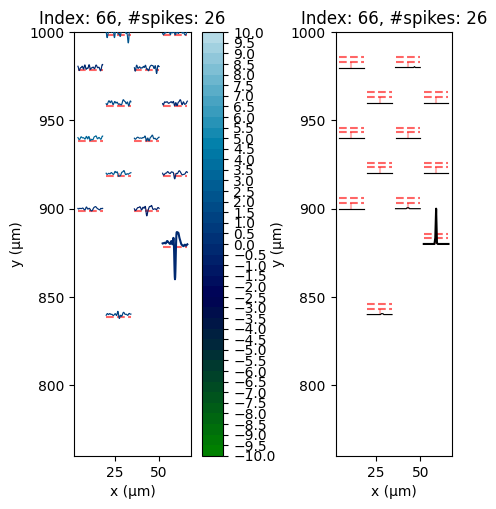

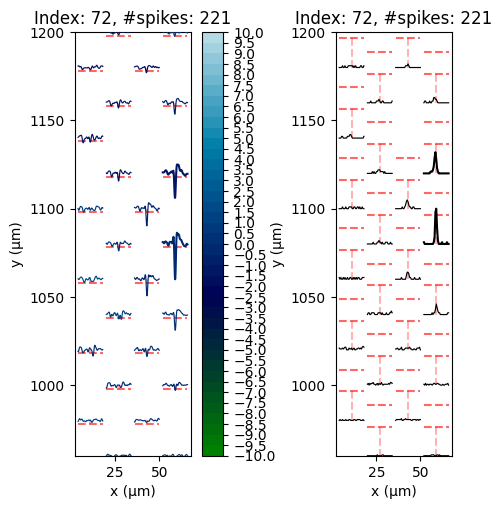

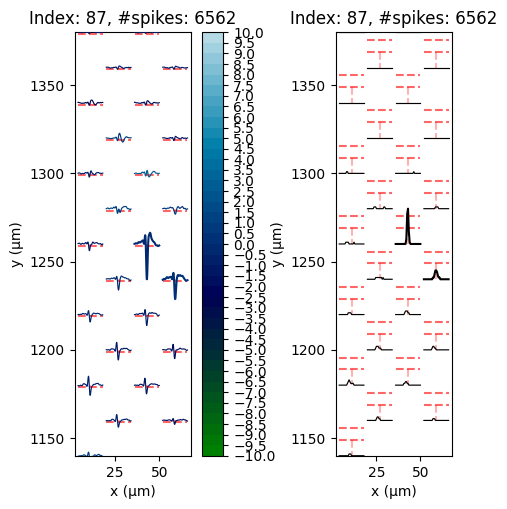

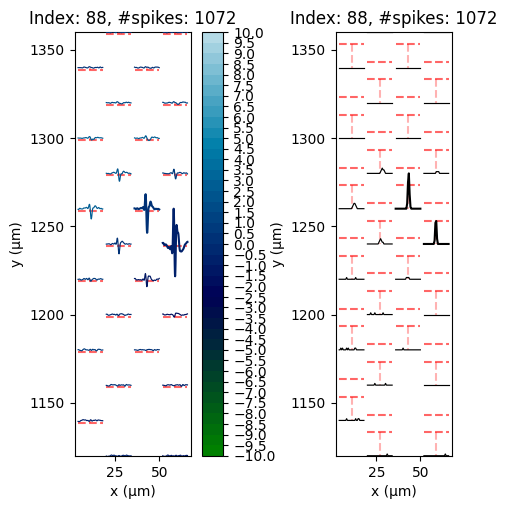

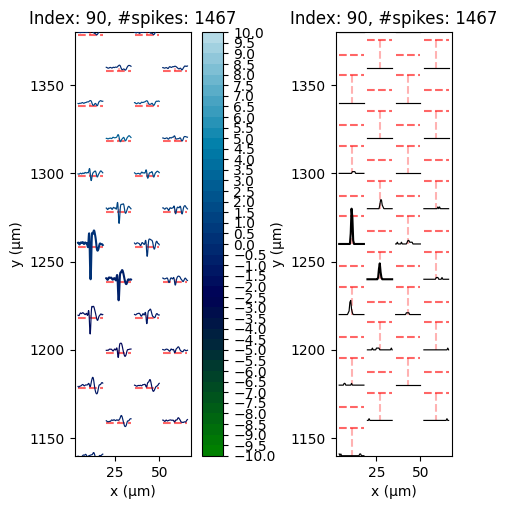

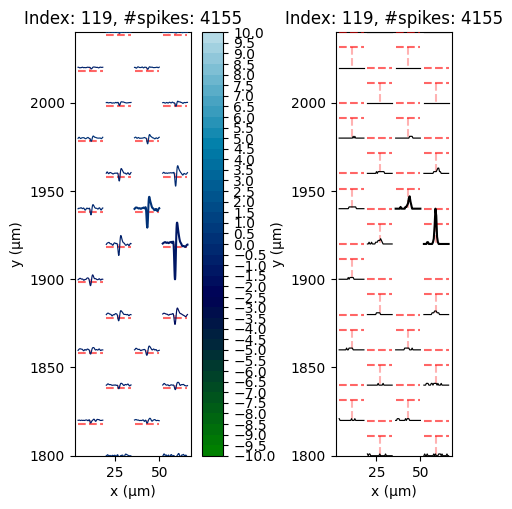

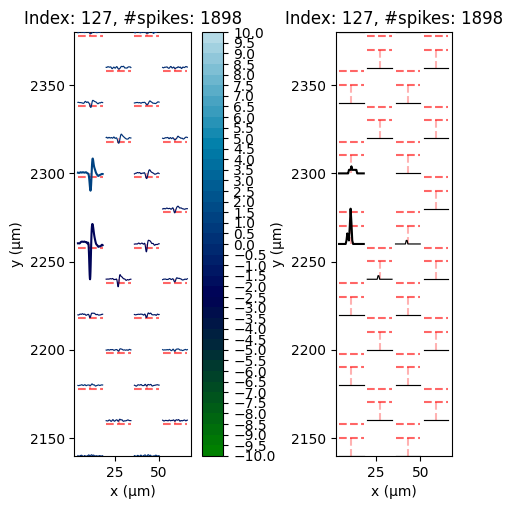

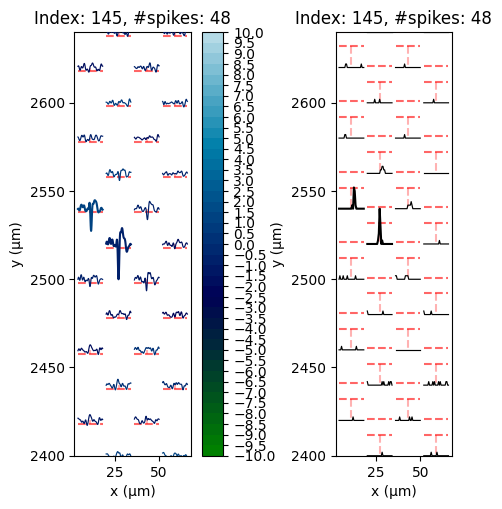

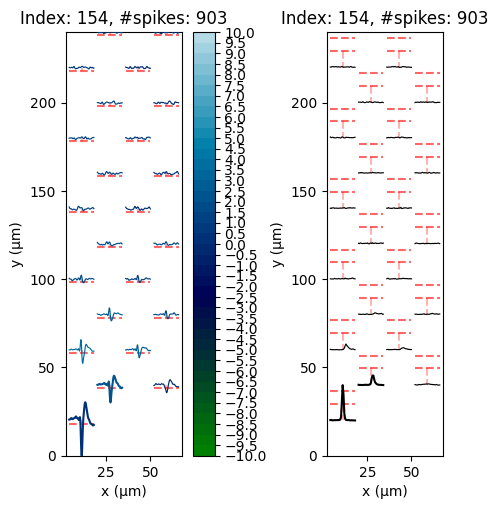

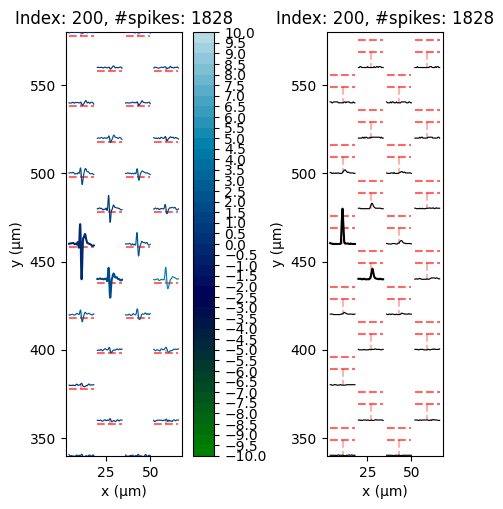

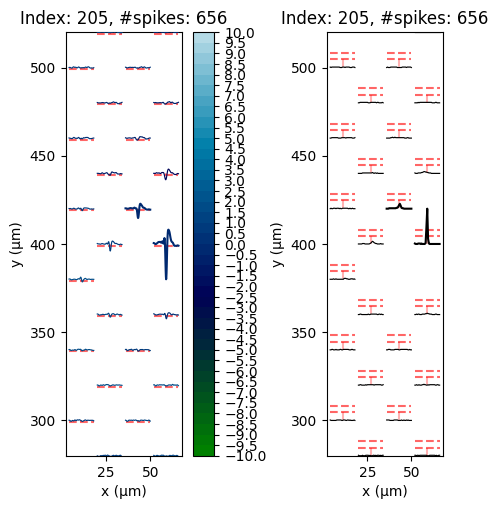

In [120]:
for ks_unit, prop_unit in zip(all_ks_units, all_prop_units):
    # print("-"*50)
    if len(prop_unit.spike_train) > 0:
        continue
    amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
    plt.show()
    # F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    # plt.show()
    

In [106]:
# Get spike data for kilosort only spikes
F.set_ks_only_spike_match_scores(ks_only_units, all_ks_sequences)

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [13:20<00:00,  3.80s/it]

Undetectable sequences: []


In [ ]:
# Fix unit.time_to_spike_match if changes are needed
# for unit in ks_only_units:
#     for time in unit.time_to_spike_match:
#         data = unit.time_to_spike_match[time]
#         if data[1] < 2:
#             unit.time_to_spike_match[time] = [data[0], data[1], data[2], np.nan, np.nan, np.nan, np.nan]

Num. inner loose electrodes


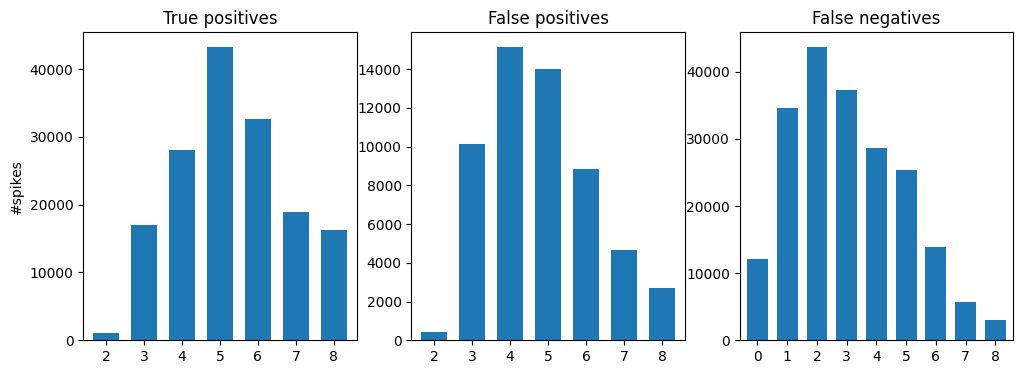

In [107]:
"""
For each metric, plot histograms for all:
    1. True positives (prop_and_ks_units)
    2. False positives (prop_only_units)
    3. False negatives (ks_only_units)
    
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)
"""
metric_idx = 1  # metric index in time_to_spike_match[time]
print("Num. inner loose electrodes")  

fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
              
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Num. loose elecs


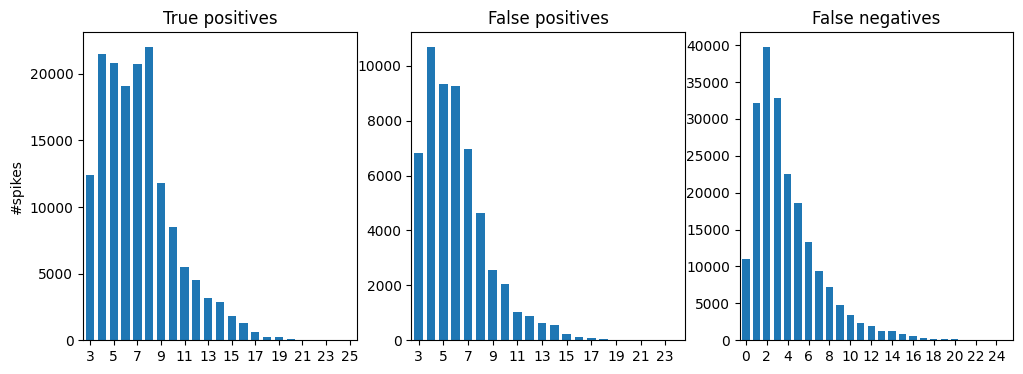

In [108]:
metric_idx = 2 
print(f"Num. loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

for ax in (a0, a1, a2):
    ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Percent loose elecs


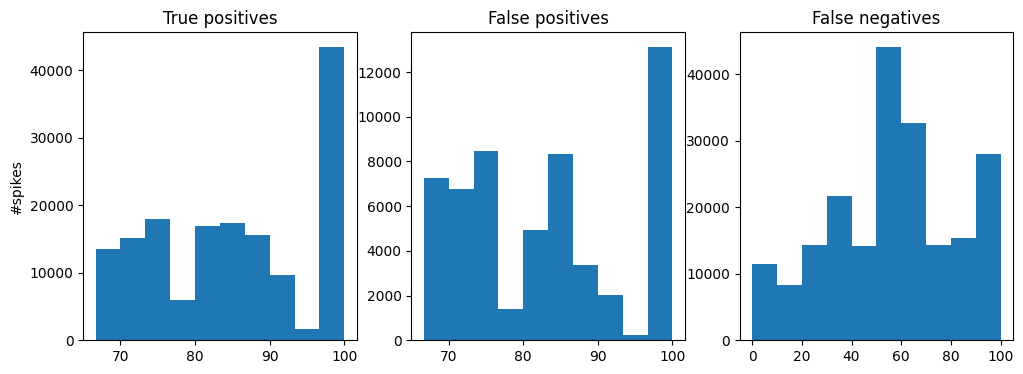

In [112]:
metric_idx = 3
print(f"Percent loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 10}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)

# for ax in (a0, a1):
#     ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Latency difference


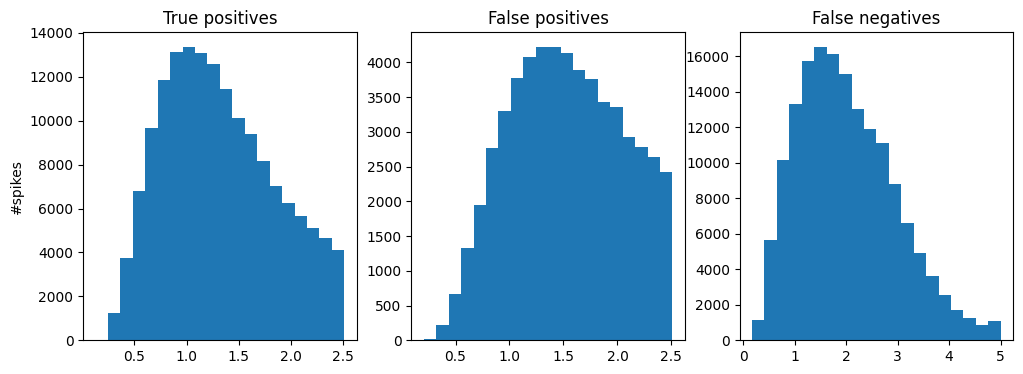

In [113]:
metric_idx = 4
print(f"Latency difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(true_positives, axis=a0, **kwargs)
plot.hist(false_positives, axis=a1, **kwargs)
plot.hist(false_negatives, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Amplitude difference


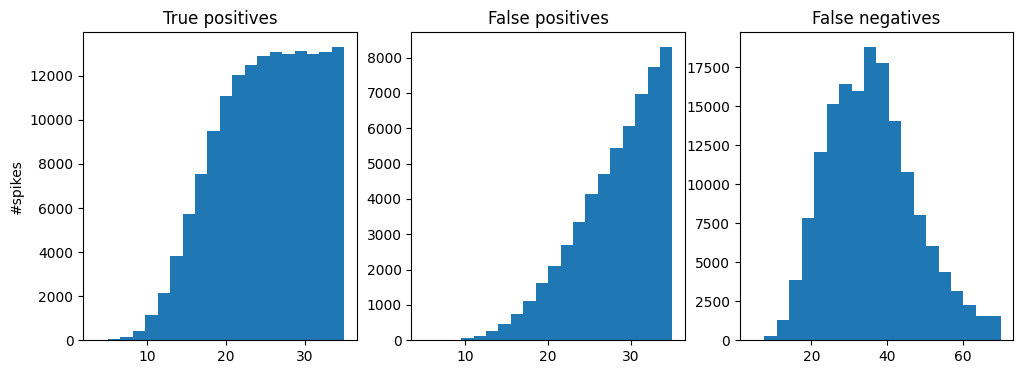

In [114]:
metric_idx = 5
print(f"Amplitude difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

#### Scatter plots
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)

In [115]:
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)

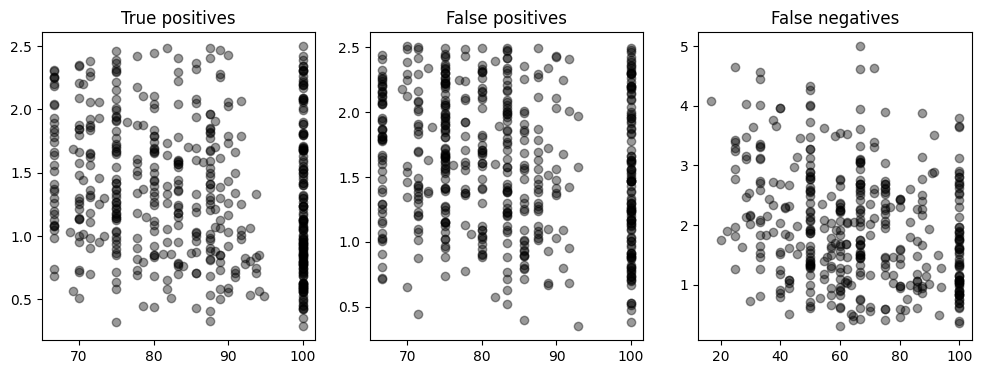

In [116]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 4  # latency_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric]
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

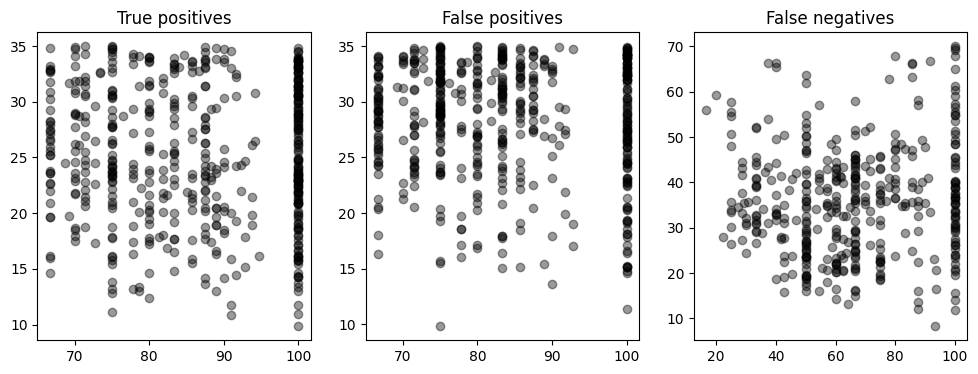

In [117]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

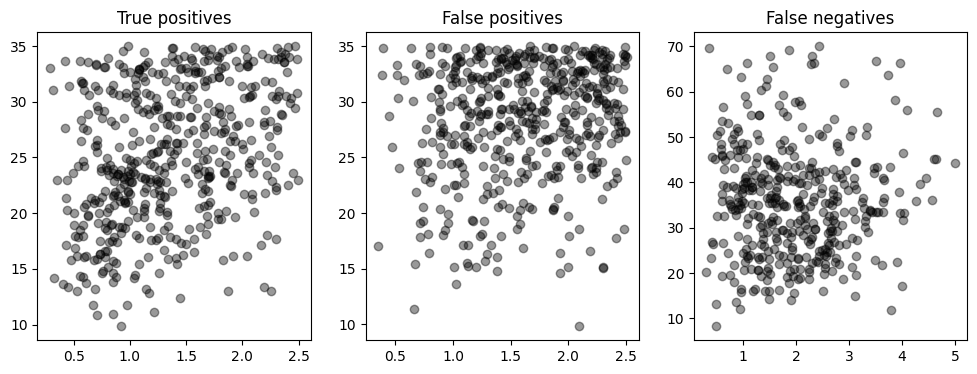

In [118]:
x_metric = 4  # latency_diff 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] 
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

#### Precision and recall after each spike assignment threshold

In [94]:
assert False, "This does not work because it does not account for the new false negatives caused by loosening thresholds"

PARAM_TESTS = (
    # (2, 3, 2/3, 2.51, 0.35),
    (-np.inf, -np.inf, -np.inf, np.inf, np.inf),
    # (-np.inf, 3, -np.inf, np.inf, np.inf),
    # (2, 3, -np.inf, np.inf, np.inf),
    # (2, 3, 2/3, np.inf, np.inf),
    # (2, 3, 2/3, 2.51, np.inf),
    # (2, 3, -np.inf, np.inf, 0.35)
    # (2, 3, 2/3, 2.51, 0.35),
    
    # (2, 3, -np.inf, 2.51, 0.35),
    # (2, 3, -np.inf, 4, 0.35), 
    # (2, 3, -np.inf, 2.51, 0.50), 
    # (2, 3, -np.inf, 4, 0.50), 
    # (2, 3, -np.inf, 5, 0.7), 
)
##
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
for (min_inner_loose_detections, min_loose_detections_n, min_loose_detections_r, max_latency_diff, max_amp_median_diff) in PARAM_TESTS:
    num_tp = num_fp = num_fn = 0
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_true_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_negatives:
        if np.isnan(latency_diff):
            num_fn += 1
        elif num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fn += 1
    
    print(f"{min_inner_loose_detections}_{min_loose_detections_n}_{min_loose_detections_r*100:.0f}%, {max_latency_diff} frames, {max_amp_median_diff}%")
    print(f"Precision: {num_tp / (num_tp+num_fp) *100:.1f}%")
    print(f"Recall: {num_tp / (num_tp + num_fn) *100:.1f}%")
    print()
    
    # Probably because of spike splitting, precision and recall when using correct thresholds are slightly difference

-inf_-inf_-inf%, inf frames, inf%
Precision: 84.9%
Recall: 87.1%



#### Footprints

--------------------------------------------------


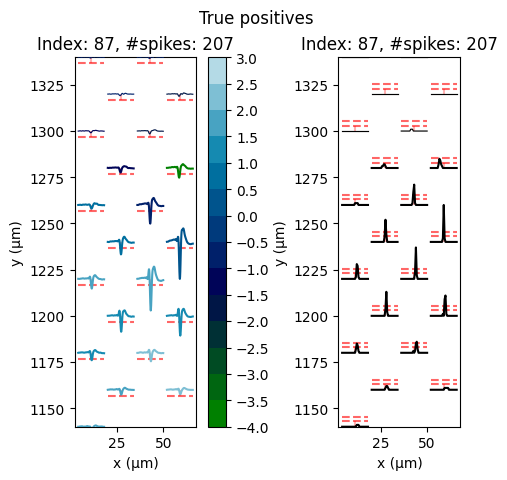

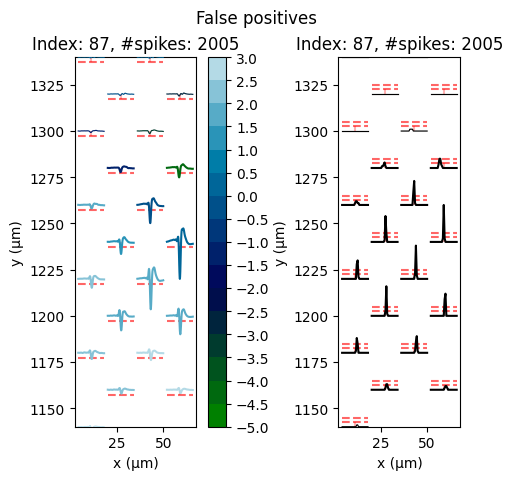

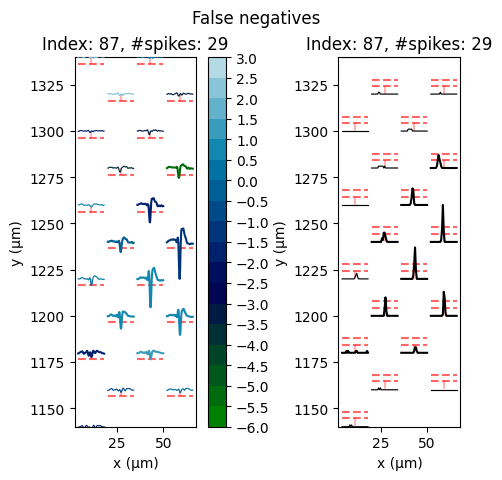

In [ ]:
num_units = 1
##
np.random.seed(231)
ind = np.random.choice(len(prop_and_ks_units), num_units)

# for prop_and_ks, prop_only, ks_only in zip(prop_and_ks_units, prop_only_units, ks_only_units):
for idx in ind:
    prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]
    print("-"*50)
    
    F.plot_elec_probs(prop_and_ks)
    plt.suptitle("True positives")
    plt.show()
    
    F.plot_elec_probs(prop_only)
    plt.suptitle("False positives")
    plt.show()
    
    F.plot_elec_probs(ks_only)
    plt.suptitle("False negatives")
    plt.show()

#### Save footprints

In [122]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints")

In [123]:
for prop_and_ks, prop_only, ks_only in zip(tqdm(prop_and_ks_units), prop_only_units, ks_only_units):
    # For testing
    # idx = 44
    # prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]

    save_path = SAVE_ROOT / str(prop_and_ks.idx)
    save_path.mkdir(parents=True, exist_ok=True)

    if len(prop_and_ks.spike_train) > 0:
        F.plot_elec_probs(prop_and_ks)
        plt.suptitle("True positives")
        plt.savefig(save_path / "true_positives.jpg", format="jpg")
        plt.close()

    if len(prop_only.spike_train) > 0:
        F.plot_elec_probs(prop_only)
        plt.suptitle("False positives")
        plt.savefig(save_path / "false_positives.jpg", format="jpg")
        plt.close()

    if len(ks_only.spike_train) > 0:
        F.plot_elec_probs(ks_only)
        plt.suptitle("False negatives")
        plt.savefig(save_path / "false_negatives.jpg", format="jpg")
        plt.close()

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [10:46<00:00,  3.06s/it]


### Development

##### 12/29/23 - Why so many spikes missed by RT-Sort?

In [71]:
IDX = 1
OVERLAP_TIME = 0.4

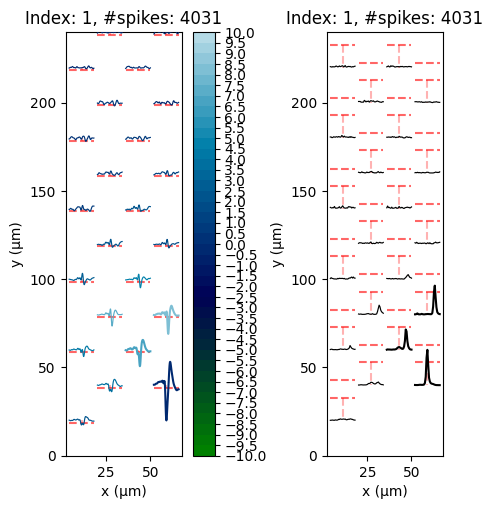

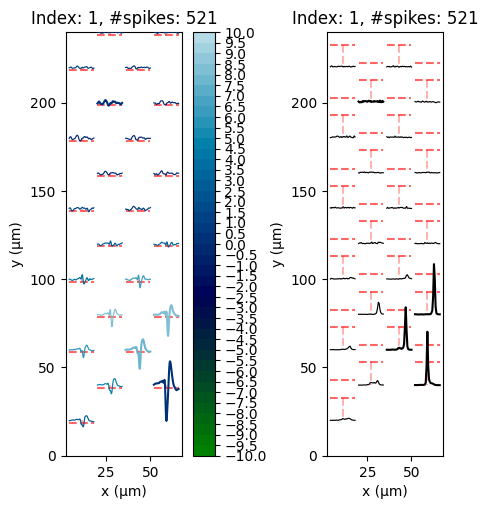

In [72]:
ks_unit = all_ks_units[IDX]
prop_unit = all_prop_units[IDX]
## 
amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
plt.show()
F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

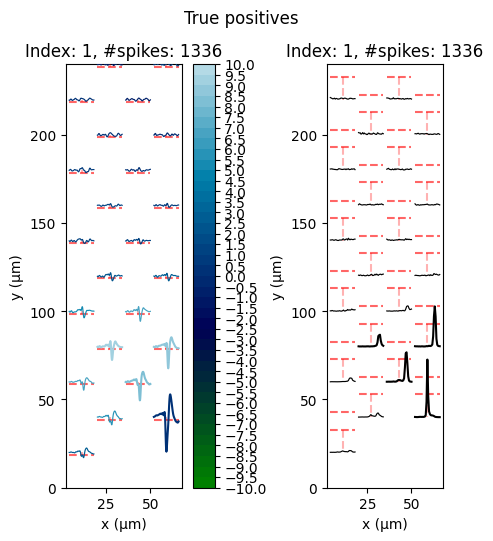

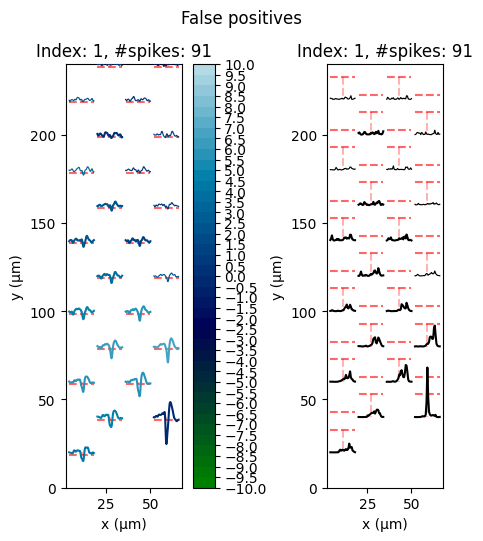

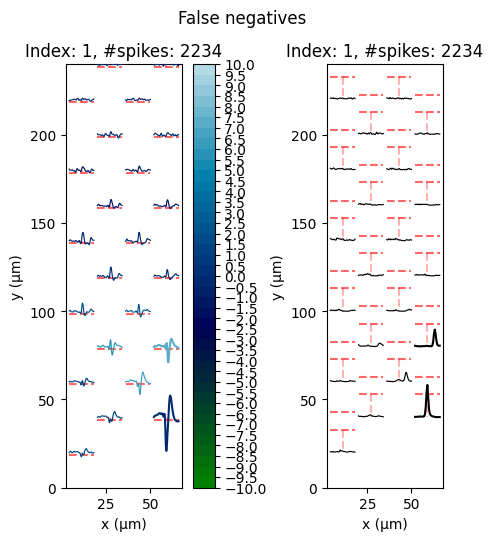

In [20]:
F.plot_elec_probs(prop_and_ks_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("True positives")
plt.show()

F.plot_elec_probs(prop_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False positives")
plt.show()

F.plot_elec_probs(ks_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False negatives")
plt.show()

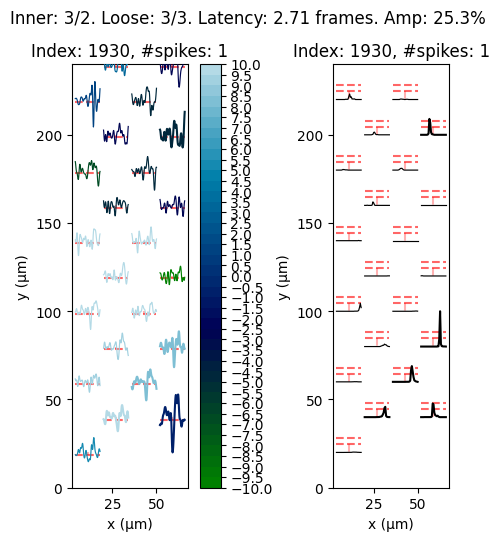

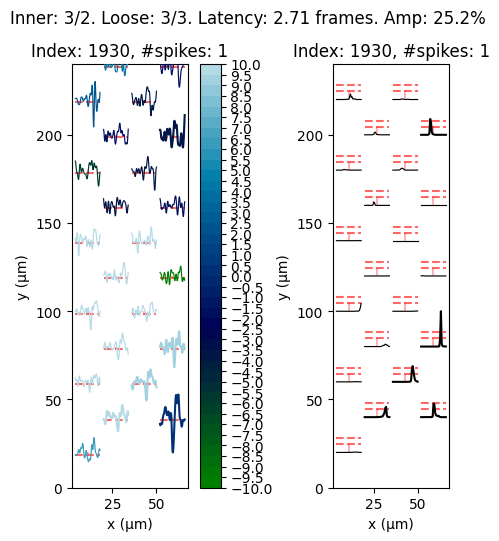

In [136]:
SPIKE_IDX = 1930
##
time = ks_only_units[IDX].spike_train[SPIKE_IDX]
F.plot_seq_spike_overlap(seq, time, SPIKE_IDX)
plt.show()

F.plot_seq_spike_overlap(seq, 207257.033333, SPIKE_IDX)
plt.show()


In [ ]:
F.assign_spikes([deepcopy(seq)], TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

In [125]:
test = F.setup_cluster(deepcopy(all_ks_sequences[1]))
test = np.sort(test)
print(np.mean(test))
print(np.mean(test[round(0.2*len(test)):-round(0.2*len(test))]))
print(np.median(test))

0.10014746770508275
0.02079222851897385
0.007289761388122044


In [84]:
all_ks_sequences[1].comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

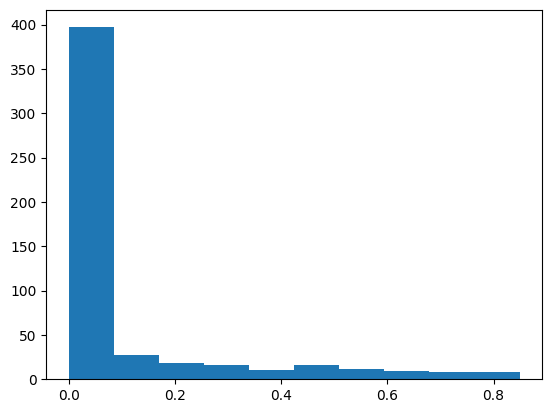

In [81]:
plt.hist(test)
plt.show()

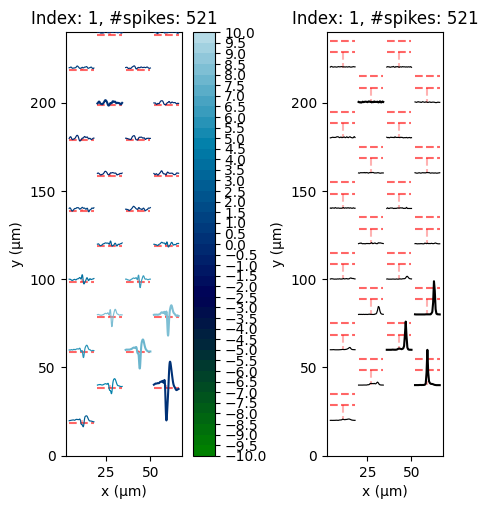

In [93]:
F.plot_elec_probs(seq)
plt.show()

In [106]:
seq.comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

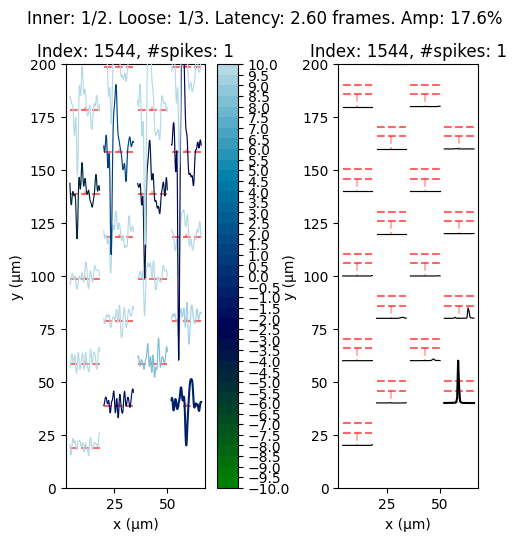

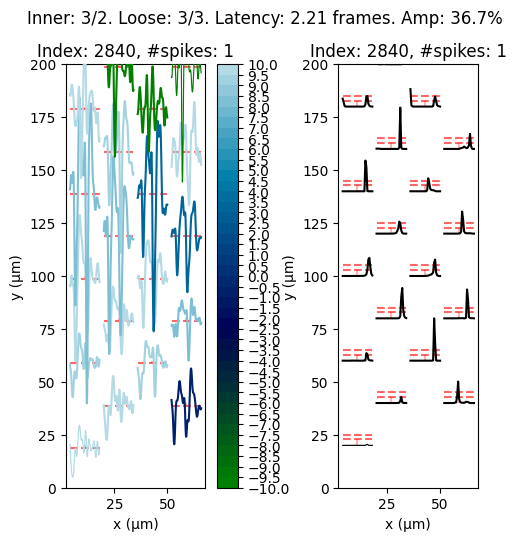

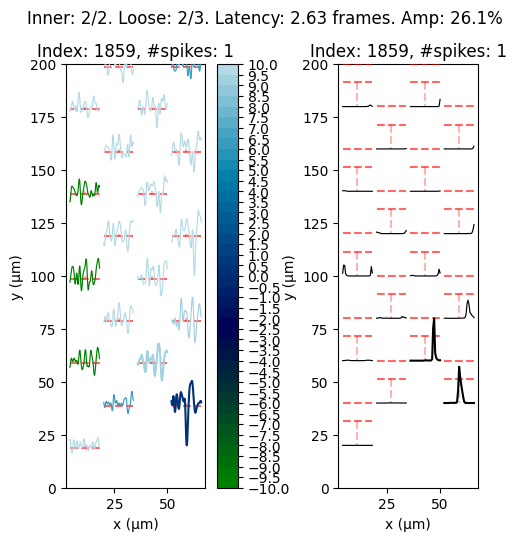

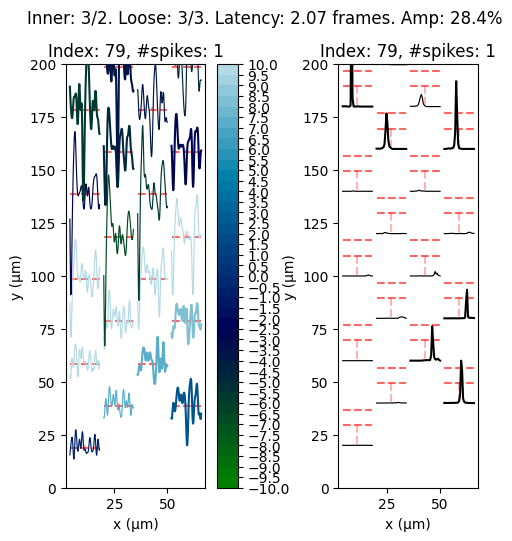

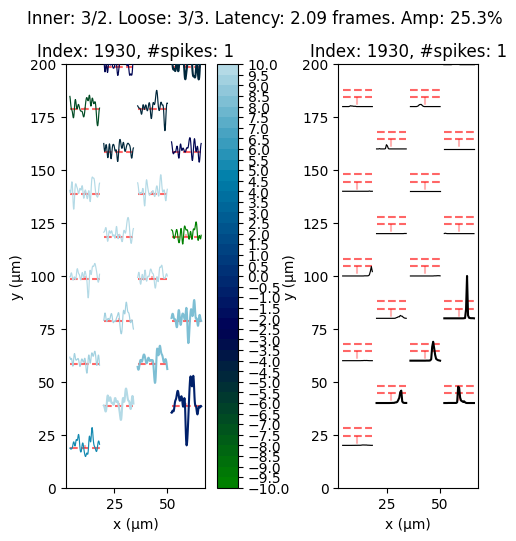

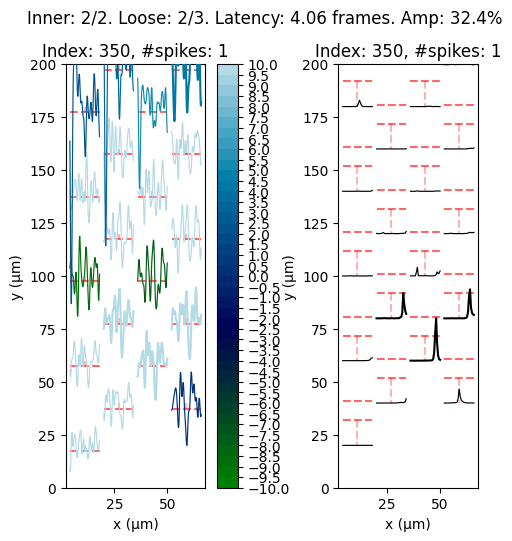

In [ ]:
np.random.seed(100)

seq = all_ks_sequences[IDX]
ks_only = ks_only_units[IDX]

for idx in np.random.choice(len(ks_only.spike_train), 6):
    time = ks_only.spike_train[idx]
    F.plot_seq_spike_overlap(seq, time, idx)
    plt.show()

In [ ]:
seq = all_ks_sequences[IDX]

latency_diffs = []
amp_median_diffs = []
for time in tqdm(ks_only_units[IDX].spike_train):
    latency_diff, amp_median_diff = F.get_seq_spike_overlap(seq, time)
    latency_diffs.append(latency_diff)
    amp_median_diffs.append(amp_median_diff)

100%|██████████| 3336/3336 [00:14<00:00, 229.64it/s]


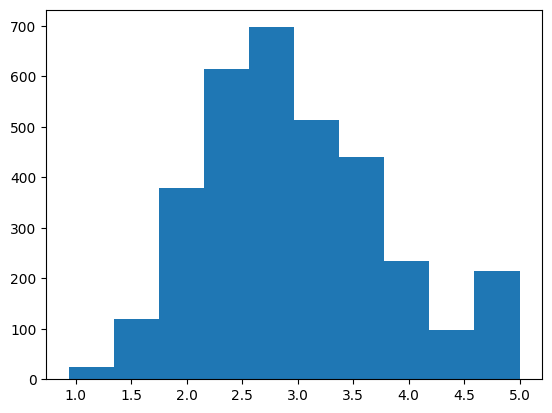

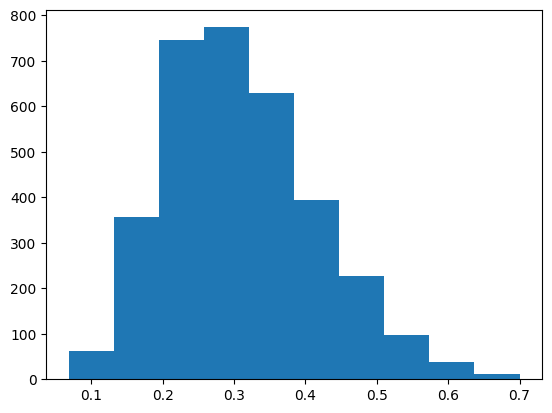

In [ ]:
plt.hist(latency_diffs)
plt.show()
plt.hist(amp_median_diffs)
plt.show()

In [ ]:
sequence = all_ks_sequences[IDX]
count = 0
for spike in ks_unit.spike_train:
    if spike in sequence.time_to_spike_match:
        count += 1
# true_positives, false_positives, false_negatives = Comparison.get_matching_events(ks_unit.spike_train, prop_unit.spike_train)
detectable_times = list(sequence.time_to_spike_match.keys())  # All spikes that can be detected by RT-Sort (detected on at least two elecs by DL model)
detectable_times = np.sort(detectable_times)

# Get ks's closest spike match in time_to_spike_match (upper bound of #matches, i.e. only requirement is DL model detecting on at least two elecs)
max_num_matches = 0  
for ks_spike in ks_unit.spike_train:
    _, prop_spike = utils.find_closest(detectable_times, ks_spike)
    if np.abs(prop_spike - ks_spike) <= OVERLAP_TIME:
        max_num_matches += 1
print(f"Maximum #matches: {max_num_matches}")

Maximum #matches: 2761


In [ ]:
print(f"All stringnet + >=1 loose DL detections:", len(detectable_times))

All stringnet + >=1 loose DL detections: 10829
